# Data loading

In [3]:
import pandas as pd
# Load the CSV file
file_path='data'
#!ls '/content/drive/My Drive/SHAP'
df_aqi_daily = pd.read_csv(file_path+"/dataset_aqi_daily.csv")
df_processed_combined_data_daily_daily = pd.read_csv(file_path+"/processed_combined_data_daily.csv")

df_aqi_daily.DateTime = pd.to_datetime(df_aqi_daily.DateTime)
df_processed_combined_data_daily_daily.DateTime = pd.to_datetime(df_processed_combined_data_daily_daily.DateTime)


In [4]:
df_aqi_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1815 entries, 0 to 1814
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  1815 non-null   datetime64[ns]
 1   AQI       1815 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 28.5 KB


In [5]:
df_processed_combined_data_daily_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2179 entries, 0 to 2178
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   DateTime        2179 non-null   datetime64[ns]
 1   wind_speed      1461 non-null   float64       
 2   wind_direction  1454 non-null   float64       
 3   precipitation   2165 non-null   float64       
 4   pressure        2178 non-null   float64       
 5   temperature     2179 non-null   float64       
 6   humidity        2165 non-null   float64       
 7   visibility      2178 non-null   float64       
 8   cloudiness      2178 non-null   float64       
 9   Bjelave_PM10    1770 non-null   float64       
 10  Bjelave_SO2     1031 non-null   float64       
 11  Bjelave_NO2     1751 non-null   float64       
 12  Bjelave_O3      1658 non-null   float64       
 13  Bjelave_CO      1065 non-null   float64       
 14  Ilidža_PM2.5    1231 non-null   float64       
 15  Ilid

In [6]:
df_aqi_daily.head(1)

DateTime   AQI
0 2018-05-22  58.0

In [7]:
df_processed_combined_data_daily_daily.head()

DateTime  wind_speed  wind_direction  precipitation    pressure  \
0 2018-01-01         NaN             NaN       0.012500  940.004167   
1 2018-01-02         NaN             NaN       0.495833  936.579167   
2 2018-01-03         NaN             NaN       0.187500  937.400000   
3 2018-01-04         NaN             NaN       0.000000  935.770833   
4 2018-01-05         NaN             NaN       0.000000  937.583333   

   temperature   humidity    visibility  cloudiness  Bjelave_PM10  ...  \
0     3.316667  83.500000  17358.823529    7.117647           NaN  ...   
1     3.541667  93.041667  11216.666667    8.000000           NaN  ...   
2     3.237500  77.541667  12737.500000    7.112500     61.345475  ...   
3     1.304167  91.500000  11312.500000    6.233333     41.241054  ...   
4     5.183333  74.416667  18941.666667    5.520833     44.815521  ...   

   Ilidža_O3  Vijećnica_PM10  Vijećnica_SO2  Vijećnica_NO2  Vijećnica_CO  \
0   1.906961       71.048074      10.650870      28.662727      0.960455   
1   4.206059       33.719966      17.922083      33.315417      0.720417   
2   5.504096       29.359446      19.738750      22.959167      0.528333   
3  13.611978       48.831270      11.310417      31.575417      0.813333   
4   5.347968       42.457488       7.100417      21.552500      0.672083   

   Otoka_PM10  Otoka_SO2  Otoka_NO2  Otoka_O3  Ambasada_PM2.5  
0         NaN  40.322592  76.490469  2.376550             NaN  
1   73.208333  33.261192  45.918858  3.748420             NaN  
2   70.913043  40.278246  50.356033  8.791590             NaN  
3   75.916667  23.834154  50.982254  7.916381             NaN  
4  124.764706  33.684396  74.734574  4.557176             NaN  

[5 rows x 28 columns]

In [8]:
# Ensure DateTime column is in datetime format
df_aqi_daily['DateTime'] = pd.to_datetime(df_aqi_daily['DateTime'], dayfirst=True)  # dayfirst=True if your dates are in DD.MM.YYYY format
df_processed_combined_data_daily_daily['DateTime'] = pd.to_datetime(df_processed_combined_data_daily_daily['DateTime'], dayfirst=True)
# Filter to keep only rows before 1.1.2024
df_aqi_daily = df_aqi_daily[df_aqi_daily['DateTime'] < '2023-01-01']
df_processed_combined_data_daily_daily = df_processed_combined_data_daily_daily[df_processed_combined_data_daily_daily['DateTime'] < '2023-01-01']


#  Data imputation with neighbors processed_combined_imputed_with_neighbors_daily.csv

In [9]:
columns = ['DateTime', 'Ambasada_PM2.5','wind_speed', 'wind_direction', 'precipitation', 'pressure', 'temperature', 'humidity', 'visibility', 'cloudiness', 'Bjelave_PM10', 'Bjelave_SO2', 'Bjelave_NO2']

df_processed_combined_data_daily_daily = df_processed_combined_data_daily_daily[columns]

In [10]:
def fill_missing_days_with_neighbors(df, label):
    df.set_index('DateTime', inplace=True)
    # counts number of consecutive missing values and stores start and end date of each sequence in a list
    nan_start_end_dates = df[df[label].isnull()].groupby(df[label].notnull().cumsum()).apply(lambda x: (x.index[0], x.index[-1])).tolist()
    for start_date, end_date in nan_start_end_dates:
        # Calculate the number of missing days between the start and end date +1 because we want to include the end date
        missing_days_number = (end_date - start_date).days + 1
        print(f"Filling missing values between {start_date} and {end_date} = number of missing days: {missing_days_number}")
        # take previous and next missing_days_number days grouped by day and calculate mean for each hour
        prev_days = df.loc[start_date - pd.DateOffset(days=missing_days_number) : start_date]
        next_days = df.loc[end_date : end_date + pd.DateOffset(days=missing_days_number)]
        neighbor_days = pd.concat([prev_days, next_days])
        mean_val = neighbor_days[label].mean()
        # fill missing days with mean values
        df.loc[start_date:end_date, label] = mean_val
    df.reset_index(inplace=True)
    return df

In [11]:
total_nulls = df_aqi_daily.isnull().sum().sum()
print(f"Ukupno null vrijednosti: {total_nulls}")
#fill_missing_days_with_neighbors(df_aqi_daily,label= 'AQI')

Ukupno null vrijednosti: 0


In [12]:
for column in df_processed_combined_data_daily_daily.columns[1:]:  # Columns from index 1 to 14
    if df_processed_combined_data_daily_daily[column].isnull().any():  # Check if there are missing values
        print(f"Processing column: {column}")
        df_processed_combined_data_daily_daily = fill_missing_days_with_neighbors(df_processed_combined_data_daily_daily, column)
    else:
        print(f"No missing values in column: {column}")

Processing column: Ambasada_PM2.5
Filling missing values between 2018-01-01 00:00:00 and 2018-05-21 00:00:00 = number of missing days: 141
Filling missing values between 2019-04-11 00:00:00 and 2019-05-09 00:00:00 = number of missing days: 29
Filling missing values between 2019-06-12 00:00:00 and 2019-07-08 00:00:00 = number of missing days: 27
Processing column: wind_speed
Filling missing values between 2018-01-01 00:00:00 and 2018-12-31 00:00:00 = number of missing days: 365
Processing column: wind_direction
Filling missing values between 2018-01-01 00:00:00 and 2018-12-31 00:00:00 = number of missing days: 365
Filling missing values between 2021-11-24 00:00:00 and 2021-11-30 00:00:00 = number of missing days: 7
Processing column: precipitation
Filling missing values between 2018-09-04 00:00:00 and 2018-09-04 00:00:00 = number of missing days: 1
Filling missing values between 2018-09-08 00:00:00 and 2018-09-20 00:00:00 = number of missing days: 13
Processing column: pressure
Filling 

In [13]:
df_aqi_daily.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1685 entries, 0 to 1684
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  1685 non-null   datetime64[ns]
 1   AQI       1685 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 39.5 KB


In [14]:
df_aqi_daily.to_csv('data/processed_combined_imputed_with_neighbors_daily.csv', index=False)
df_aqi_daily.to_csv('data/processed_combined_imputed_with_neighbors_df_processed_combined_data_daily_daily.csv', index=False)

In [15]:
df_aqi_daily.tail(1)

DateTime         AQI
1684 2022-12-31  173.791667

# Data imputation with average

Filling missing values with average

In [14]:
df_aqi_daily.head(1)

DateTime   AQI
0 2018-05-22  58.0

In [15]:
def fill_missing_with_average(df, label):
    """
    Fills missing values in the 'AQI' column of the given DataFrame by taking the average value of the same month and day.
    Parameters:
    df (DataFrame): The DataFrame containing the 'DateTime' and 'AQI' columns.
    Returns:
    DataFrame: The DataFrame with the missing values in the 'AQI' column filled with the average value of the same month and day.
    """
    df['Month'] = df['DateTime'].dt.month
    df['Day'] = df['DateTime'].dt.day

    df[label] = df.groupby(['Month', 'Day'])[label].transform(lambda x: x.fillna(x.mean()))

    df.drop(columns=['Month', 'Day'], inplace=True)
    return df

In [16]:
for column in df_aqi_daily.columns[1:]:  # Columns from index 1 to 14
    if df_aqi_daily[column].isnull().any():  # Check if there are missing values
        print(f"Processing column: {column}")
        df_aqi_daily = fill_missing_with_average(df_aqi_daily, column)
    else:
        print(f"No missing values in column: {column}")

No missing values in column: AQI


In [17]:
df_aqi_daily.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1685 entries, 0 to 1684
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  1685 non-null   datetime64[ns]
 1   AQI       1685 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 39.5 KB


In [18]:
df_aqi_daily.tail(2)

DateTime         AQI
1683 2022-12-30  183.565217
1684 2022-12-31  173.791667

# Data visualisation

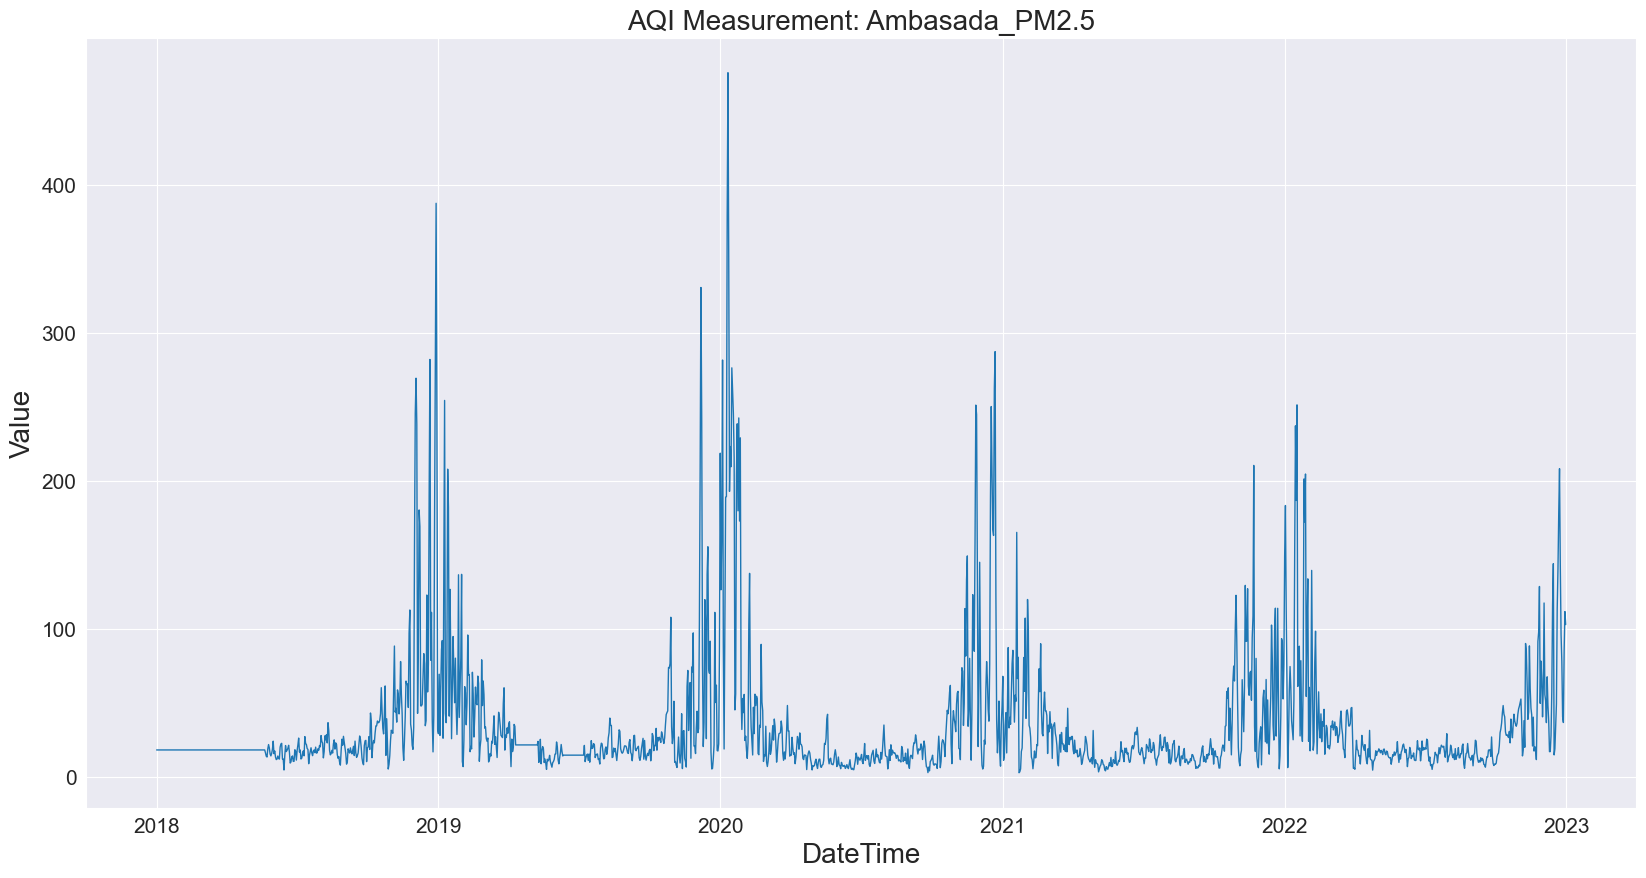

In [16]:
import matplotlib.pyplot as plt
#df_processed_combined_data_daily_daily # Plot time seris data for columns, each with its own title
#column_name = df_aqi_daily.columns[i]  # Get column name by index
plt.figure(figsize=(20, 10))
plt.plot(df_processed_combined_data_daily_daily['DateTime'], df_processed_combined_data_daily_daily['Ambasada_PM2.5'], linewidth=1)

plt.xlabel('DateTime', fontsize=20)
plt.ylabel('Value', fontsize=20)
plt.title(f'AQI Measurement: Ambasada_PM2.5', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

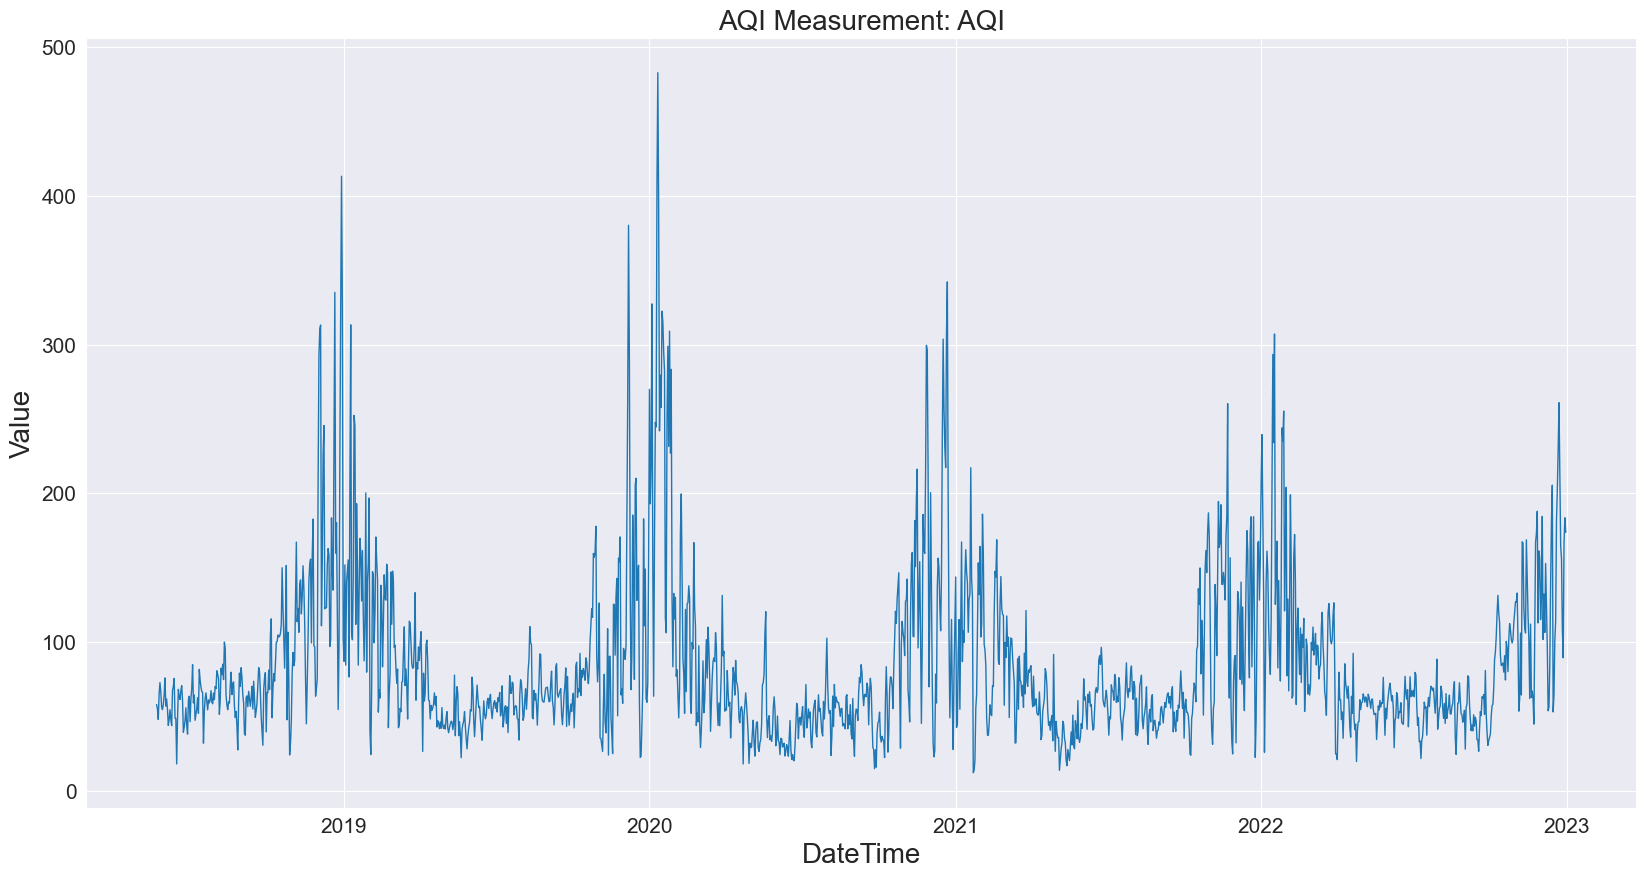

In [17]:
plt.figure(figsize=(20, 10))
plt.plot(df_aqi_daily['DateTime'], df_aqi_daily['AQI'], linewidth=1)

plt.xlabel('DateTime', fontsize=20)
plt.ylabel('Value', fontsize=20)
plt.title(f'AQI Measurement: AQI', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

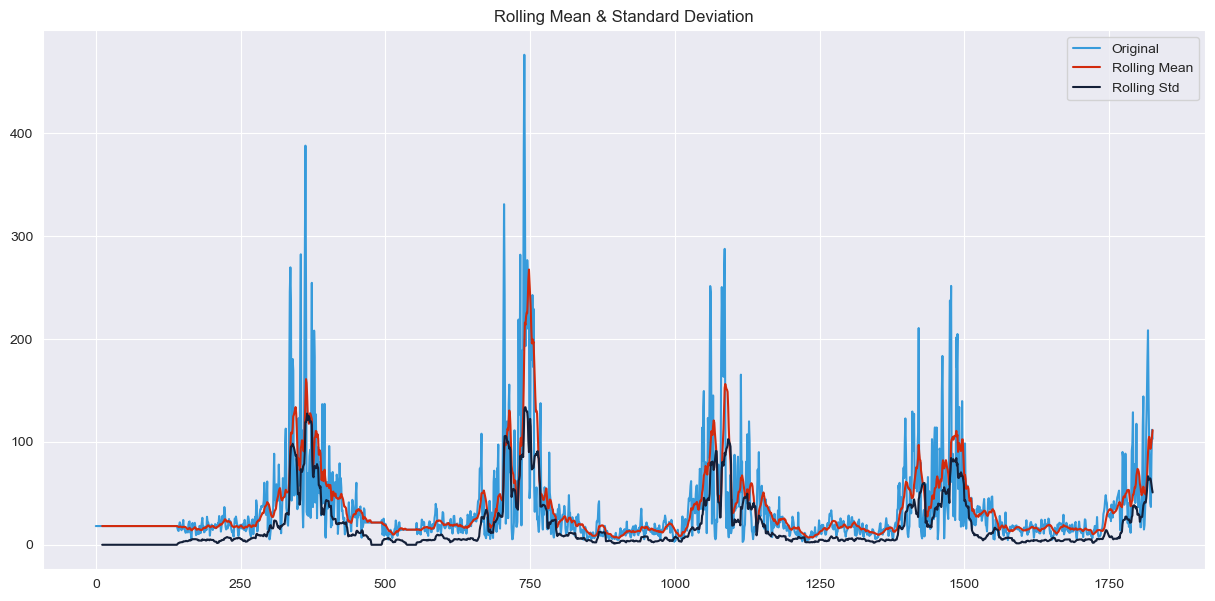

In [18]:
# df_processed_combined_data_daily_daily
rolling_avg = df_processed_combined_data_daily_daily["Ambasada_PM2.5"].rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
rolling_std = df_processed_combined_data_daily_daily["Ambasada_PM2.5"].rolling(window=12).std()

#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(df_processed_combined_data_daily_daily["Ambasada_PM2.5"], color='#379BDB', label='Original')
plt.plot(rolling_avg, color='#D22A0D', label='Rolling Mean')
plt.plot(rolling_std, color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

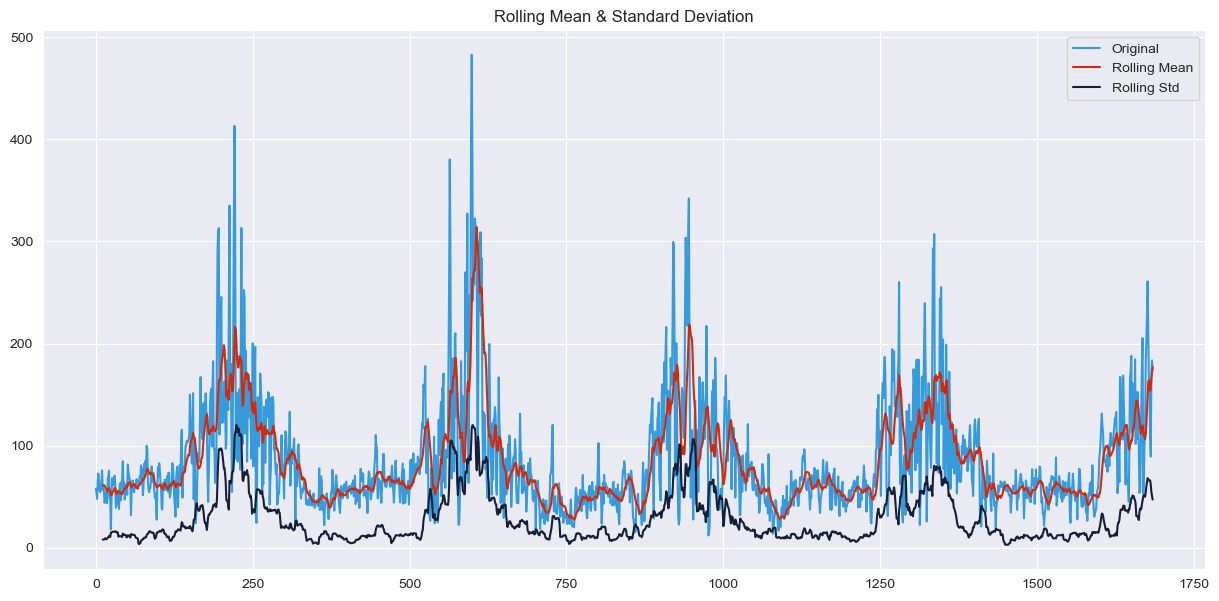

In [19]:
plt.show()
# df_processed_combined_data_daily_daily
rolling_avg = df_aqi_daily["AQI"].rolling(
    window=12).mean()  #window size 12 denotes 12 months, giving rolling mean at yearly level
rolling_std = df_aqi_daily["AQI"].rolling(window=12).std()

#Plot rolling statistics
plt.figure(figsize=(15, 7))
plt.plot(df_aqi_daily["AQI"], color='#379BDB', label='Original')
plt.plot(rolling_avg, color='#D22A0D', label='Rolling Mean')
plt.plot(rolling_std, color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

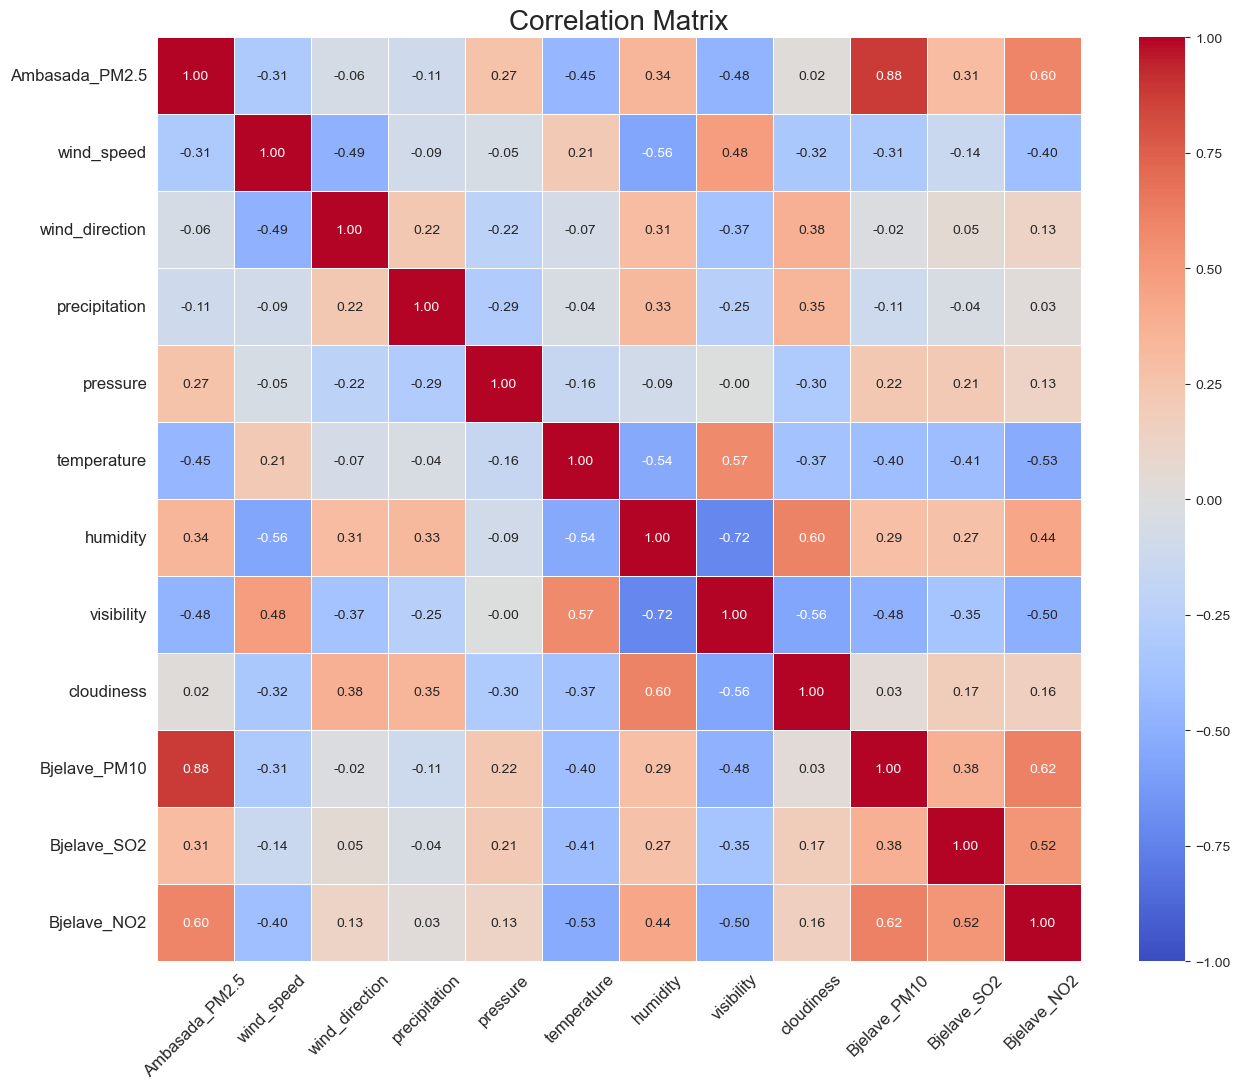

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select columns with index 1 to 13
selected_columns = df_processed_combined_data_daily_daily.iloc[:, 1:]

# Calculate correlation matrix
correlation_matrix = selected_columns.corr()

# Plot correlation matrix
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, square=True, linewidths=0.5, fmt=".2f")
plt.title('Correlation Matrix', fontsize=20)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.show()


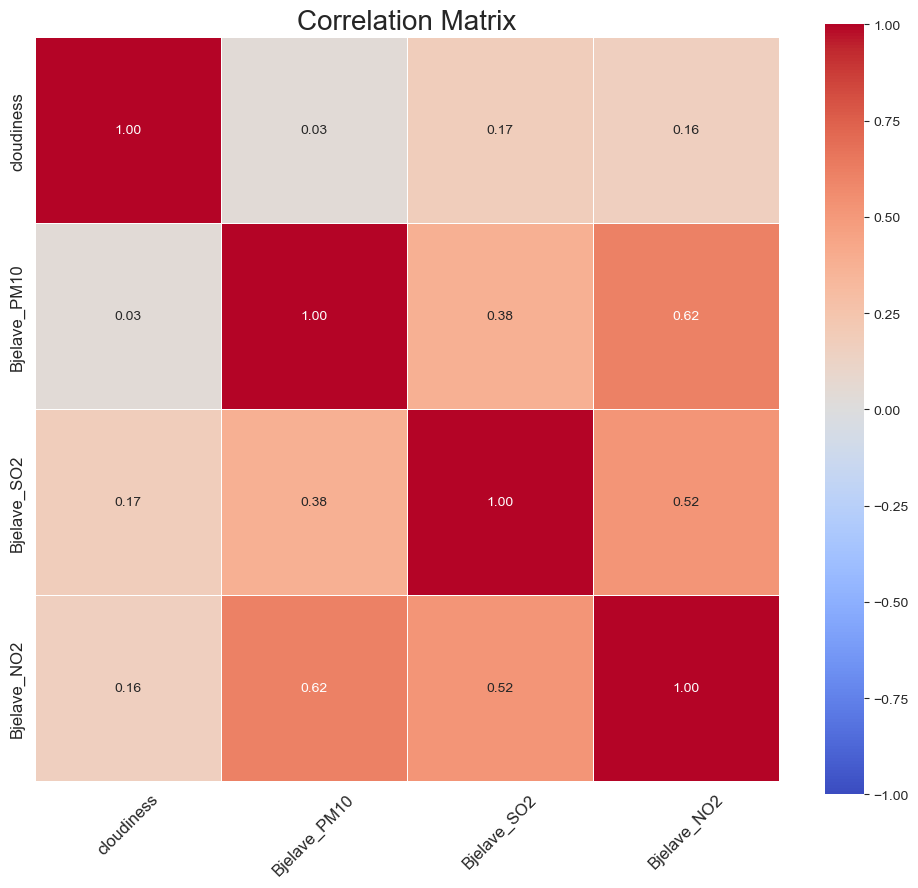

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select columns with index 1 to 13
selected_columns = df_processed_combined_data_daily_daily.iloc[:, 9:]

# Calculate correlation matrix
correlation_matrix = selected_columns.corr()

# Plot correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, square=True, linewidths=0.5, fmt=".2f")
plt.title('Correlation Matrix', fontsize=20)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.show()

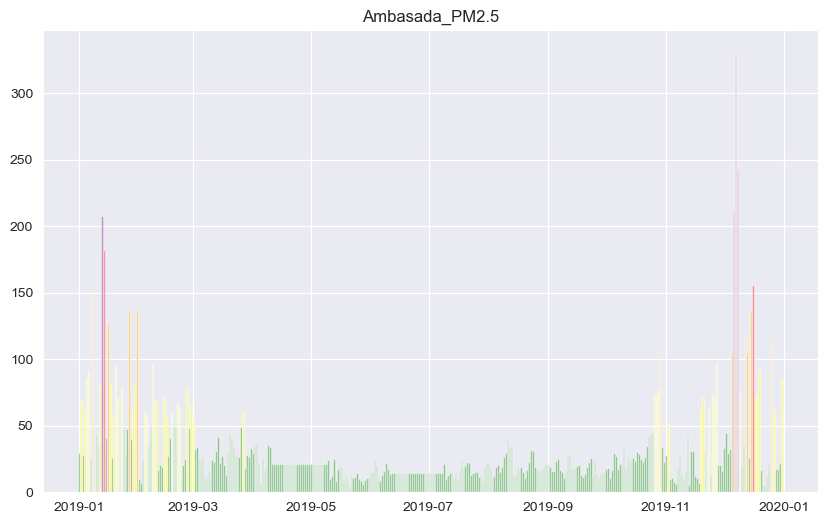

In [22]:
def plot_colored(df, start_date, end_date, label, categories):
    time_period = pd.date_range(start_date, end_date, freq='D')
    df = df[(df['DateTime'] >= start_date) & (df['DateTime'] <= end_date)]

    plt.figure(figsize=(10,6))

    for category in categories:
        color, start, end = category
        # plt.plot(df.loc[mask, label], color=color)
        # plt.hist(df.loc[(df[label] >= start) & (df[label] <= end), label], bins=20, color=color, alpha=0.5)
        plt.bar(df.loc[(df[label] >= start) & (df[label] <= end), "DateTime"], df.loc[(df[label] >= start) & (df[label] <= end), label], color=color, alpha=0.5)

    plt.title(label)
    plt.show()

categories = [('green', 0, 50), ('yellow', 51, 100), ('orange', 101, 150), ('red', 151, 200), ('purple', 201, 250), ('brown', 300, df_processed_combined_data_daily_daily['Ambasada_PM2.5'].max())]
plot_colored(df_processed_combined_data_daily_daily, '2019-01-01', '2019-12-31', 'Ambasada_PM2.5', categories)

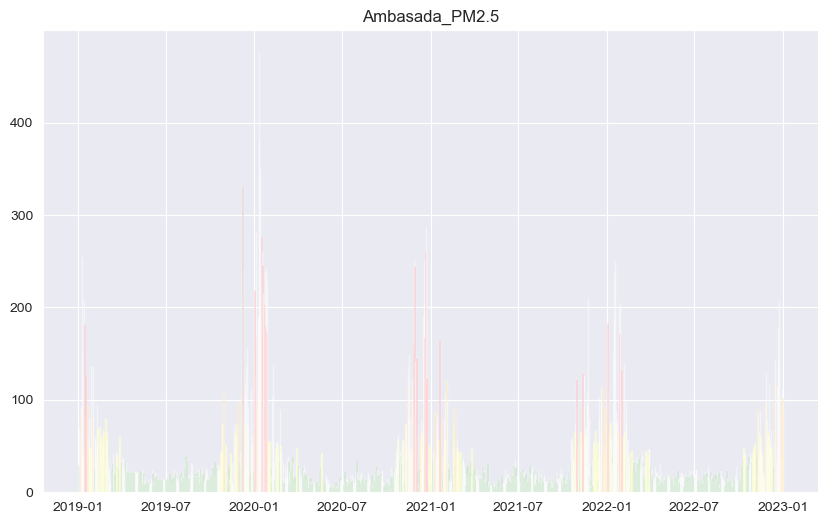

In [23]:
#iz time_series_vs_regression.ipynb
def plot_colored(df, start_date, end_date, label, categories):
    time_period = pd.date_range(start_date, end_date, freq='D')
    df = df[(df['DateTime'] >= start_date) & (df['DateTime'] <= end_date)]

    plt.figure(figsize=(10,6))

    for category in categories:
        color, start, end = category
        # plt.plot(df.loc[mask, label], color=color)
        # plt.hist(df.loc[(df[label] >= start) & (df[label] <= end), label], bins=20, color=color, alpha=0.5)
        plt.bar(df.loc[(df[label] >= start) & (df[label] <= end), "DateTime"], df.loc[(df[label] >= start) & (df[label] <= end), label], color=color, alpha=0.5)

    plt.title(label)
    plt.show()

categories = [('green', 0, 40), ('yellow', 40, 80), ('orange', 80, 120), ('red', 120, 300), ('brown', 300, df_processed_combined_data_daily_daily['Ambasada_PM2.5'].max())]
plot_colored(df_processed_combined_data_daily_daily, '2019-01-01', '2022-12-31', 'Ambasada_PM2.5', categories)
#categories from: https://www.epa.vic.gov.au/for-community/environmental-information/air-quality/pm10-particles-in-the-air
#this is just testing

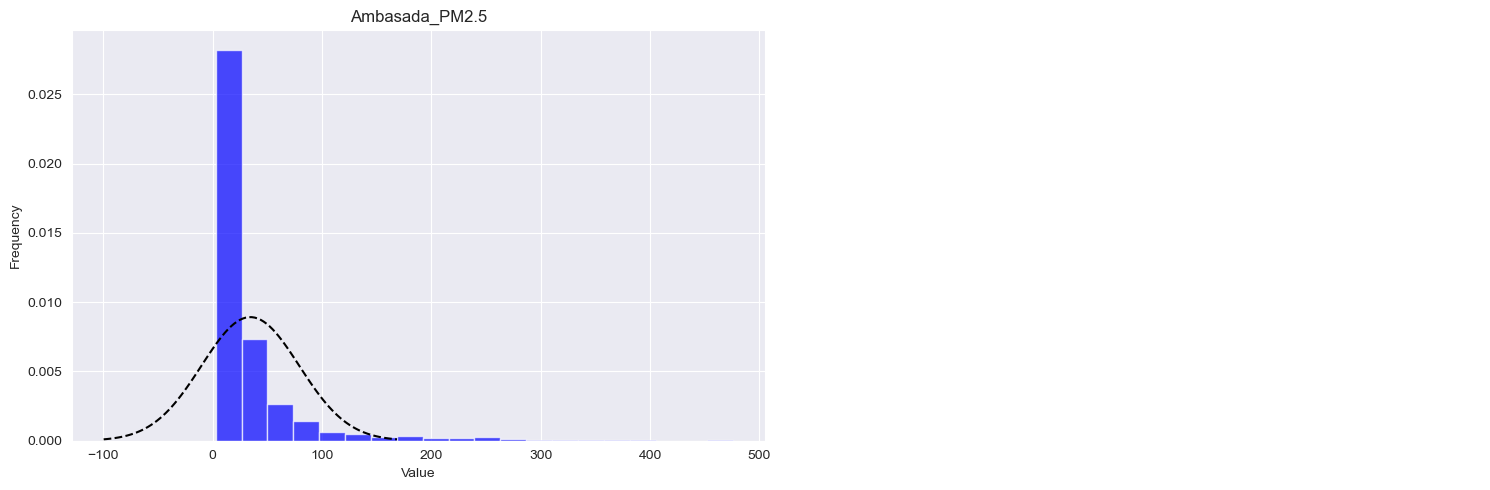

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Assuming df_aqi_daily is already defined and loaded
df = df_processed_combined_data_daily_daily
# Calculate the required number of subplots
#num_columns = len(df.columns) - 1  # Exclude the DateTime or index column
#num_rows = (num_columns + 1) // 2  # Each row has 2 subplots
num_columns = 1
num_rows = 1
# Set up the figure and axes with the new grid size
fig, axs = plt.subplots(num_rows, 2, figsize=(15, 5 * num_rows))  # Adjust height for better readability
axs = axs.flatten()

# Plotting histograms with overlaid normal distribution curve
#for i, var in enumerate(df.columns[1:]):  # Loop with index 'i' for subplots
var='Ambasada_PM2.5'
mean_val = df[var].mean()
std_val = df[var].std()
x_vals = np.linspace(mean_val - 3*std_val, mean_val + 3*std_val, 100)

    # Plot histogram
axs[0].hist(df[var], bins=20, density=True, color='blue', alpha=0.7)
    # Plot normal distribution curve
axs[0].plot(x_vals, norm.pdf(x_vals, mean_val, std_val), color='black', linestyle='dashed')

    # Set title and labels
axs[0].set_title(var)
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')

 #Hide any unused subplots
for j in range(1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

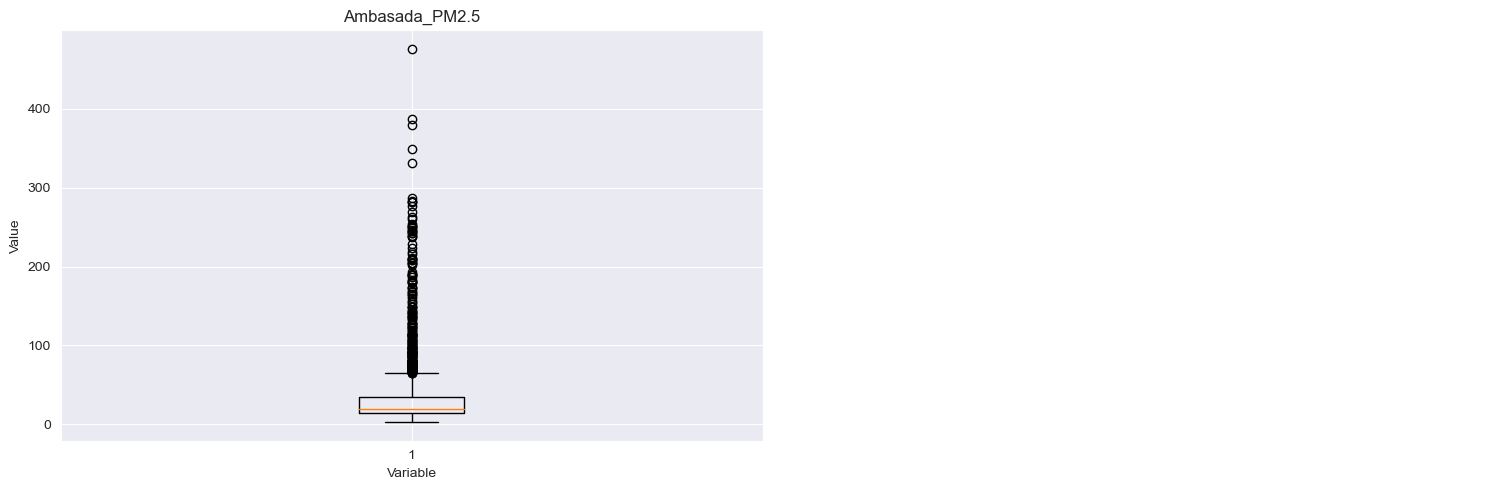

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = df_processed_combined_data_daily_daily
# Assuming `variables` is a list of column names to plot
variables = df.columns[1:]  # Example: all columns from index 1 onward
num_variables = len(variables)
# Calculate the number of rows needed for the subplots
num_cols = 2  # 2 columns per row
#num_rows = (num_variables + num_cols - 1) // num_cols  # Ceiling division to get the required rows
num_rows=1
# Set up the figure and axes with dynamic grid size
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axs = axs.flatten()  # Flatten to access with a single index

var='Ambasada_PM2.5'
# Creating box plots
i=0 # Plot box plot
axs[i].boxplot(df[var].dropna())  # Drop NaN values for boxplot

    # Set title and labels
axs[i].set_title(var)
axs[i].set_xlabel('Variable')
axs[i].set_ylabel('Value')

# Hide any unused subplots
for j in range(i + 1, len(axs)):
    axs[j].axis('off')  # Turn off unused subplots

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Dataset splitting

In [27]:
def train_test_split(df, date):
    df = df.copy()
    train_data = df[df['DateTime'] < date].copy()
    test_data = df[df['DateTime'] >= date].copy() # df.DateTime = df.DateTime.dt.strftime('%d/%m/%Y %H:%M')
    return train_data, test_data

def train_test_split_from_to(df, start_date, end_date, slice_date):
    df = df.copy()
    train_data = df[(df['DateTime'] >= start_date) & (df['DateTime'] < slice_date)].copy()
    test_data = df[(df['DateTime'] >= slice_date) & (df['DateTime'] <= end_date)].copy()
    return train_data, test_data

def plot_train_test_data(train_data, test_data, date_column, label):
    plt.figure(figsize=(20,10))
    plt.plot(train_data[date_column], train_data[label], color='blue', label='Train Data')
    plt.plot(test_data[date_column], test_data[label], color='orange', label='Test Data')
    plt.xlabel(date_column)
    plt.ylabel(label)
    plt.title(label + ' Train and Test Data')
    plt.legend()
    plt.show()

In [28]:
#input window = 30
date = df_aqi_daily['DateTime'].max() - pd.Timedelta(days=30)
train_data_aqi_ws_thirty, test_data_aqi_ws_thirty = train_test_split(df_aqi_daily, date) #

date = df_processed_combined_data_daily_daily['DateTime'].max() - pd.Timedelta(days=30)
train_data_combined_ws_thirty, test_data_combined_ws_thirty = train_test_split(df_processed_combined_data_daily_daily, date) #

#input window = 60
date = df_aqi_daily['DateTime'].max() - pd.Timedelta(days=60)
train_data_aqi_ws_sixty, test_data_aqi_ws_sixty = train_test_split(df_aqi_daily, date) #

date = df_processed_combined_data_daily_daily['DateTime'].max() - pd.Timedelta(days=60)
train_data_combined_ws_sixty, test_data_combined_ws_sixty = train_test_split(df_processed_combined_data_daily_daily, date)

#input window = 90
date = df_aqi_daily['DateTime'].max() - pd.Timedelta(days=90)
train_data_aqi_ws_ninety, test_data_aqi_ws_ninety = train_test_split(df_aqi_daily, date) #

date = df_processed_combined_data_daily_daily['DateTime'].max() - pd.Timedelta(days=90)
train_data_combined_ws_ninety, test_data_combined_ws_ninety = train_test_split(df_processed_combined_data_daily_daily, date) #


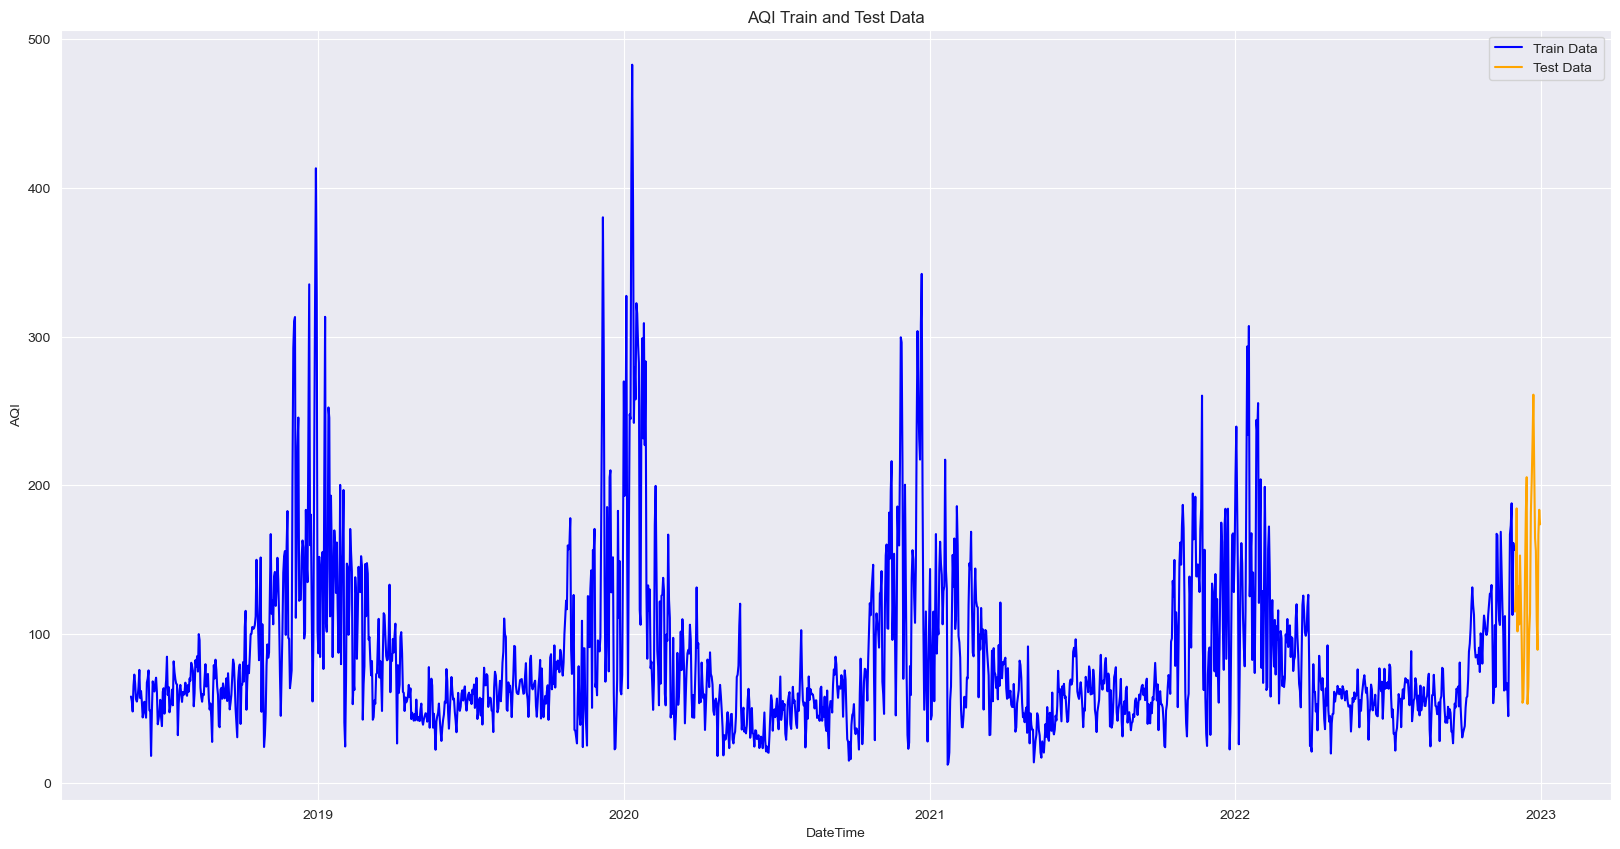

In [29]:
plot_train_test_data(train_data_aqi_ws_thirty, test_data_aqi_ws_thirty, 'DateTime', 'AQI')

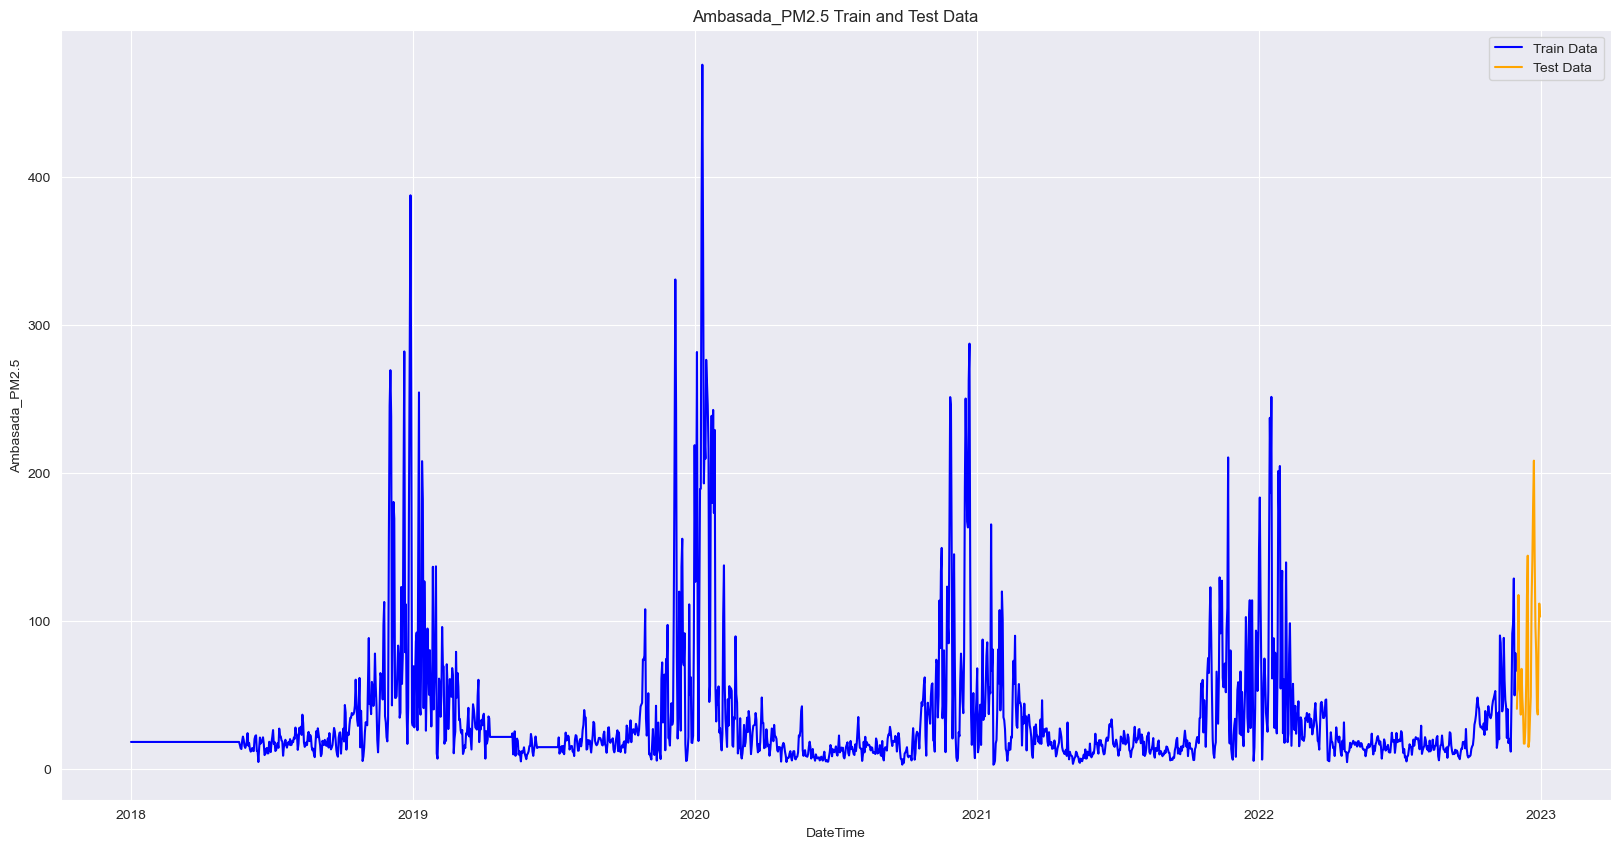

In [30]:
plot_train_test_data(train_data_combined_ws_thirty, test_data_combined_ws_thirty, 'DateTime', 'Ambasada_PM2.5')


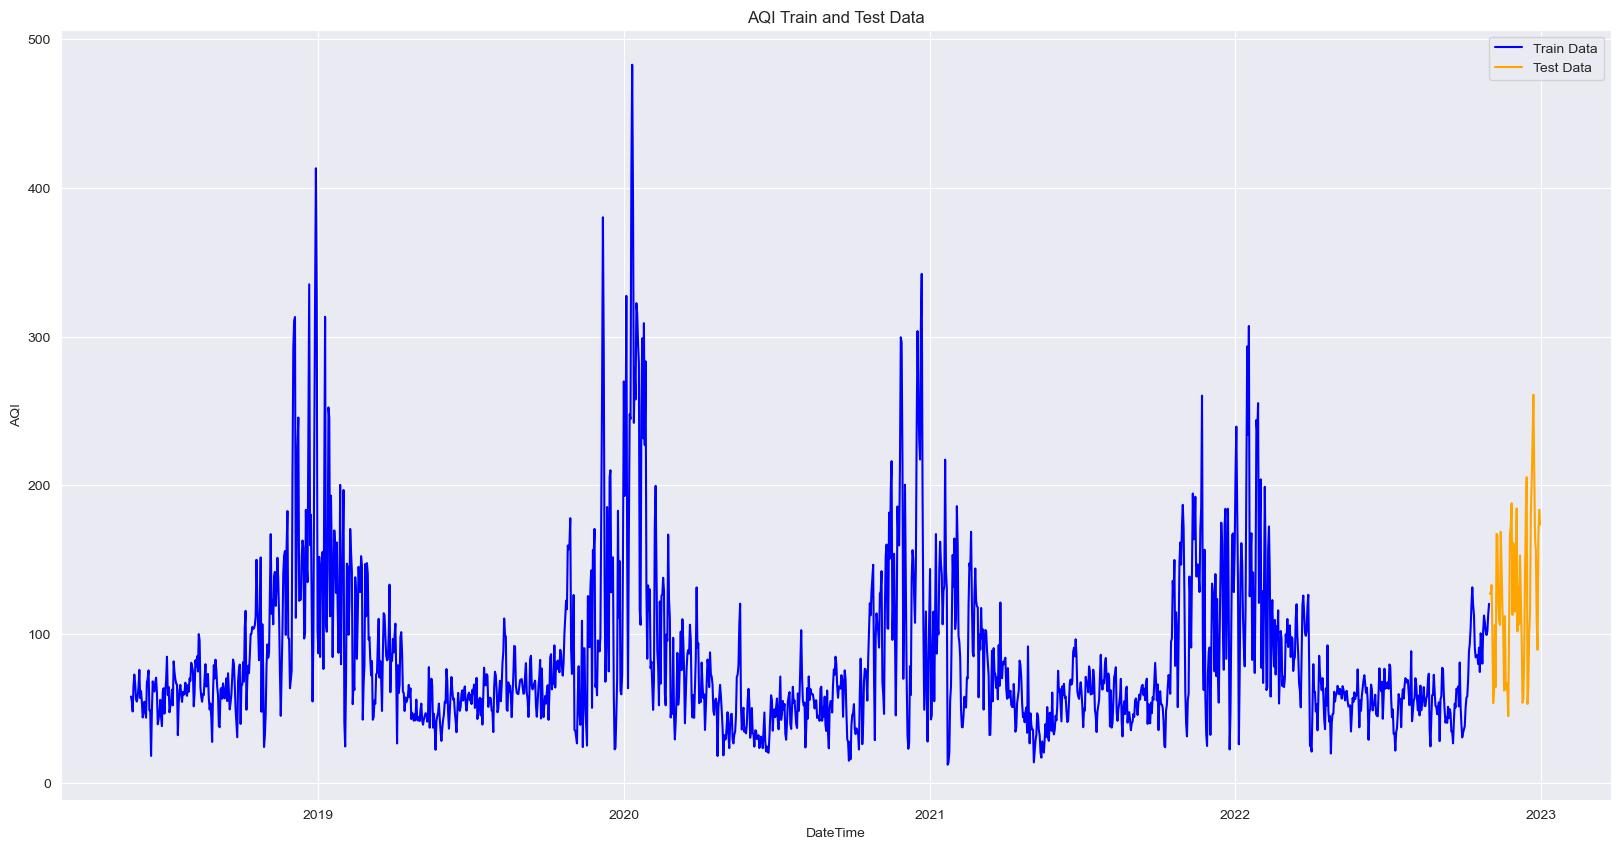

In [31]:
plot_train_test_data(train_data_aqi_ws_sixty, test_data_aqi_ws_sixty, 'DateTime', 'AQI')

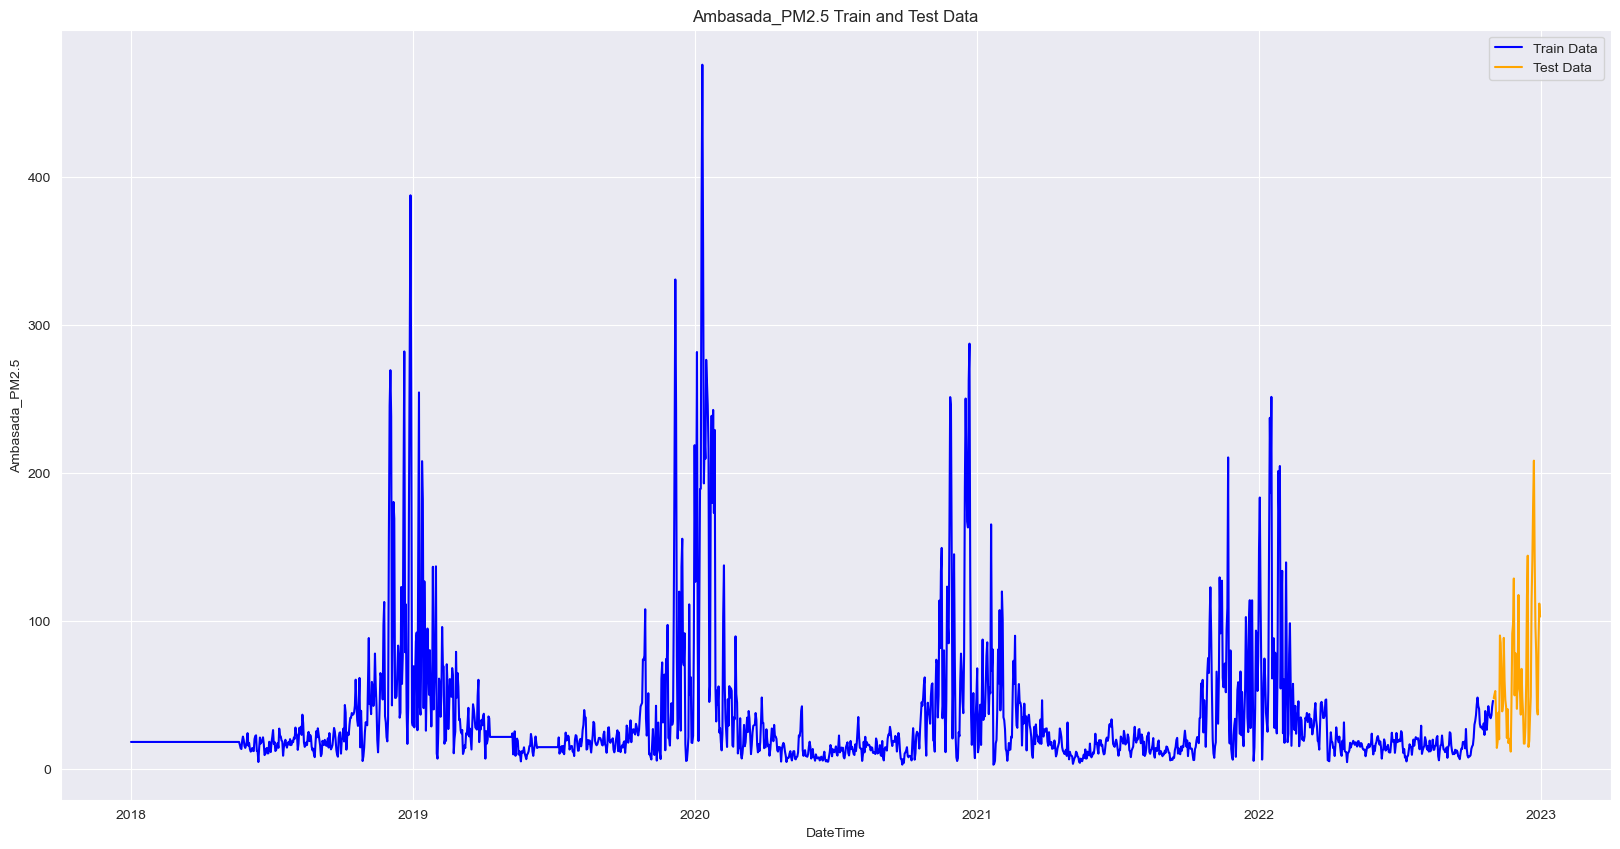

In [32]:
plot_train_test_data(train_data_combined_ws_sixty, test_data_combined_ws_sixty, 'DateTime', 'Ambasada_PM2.5')

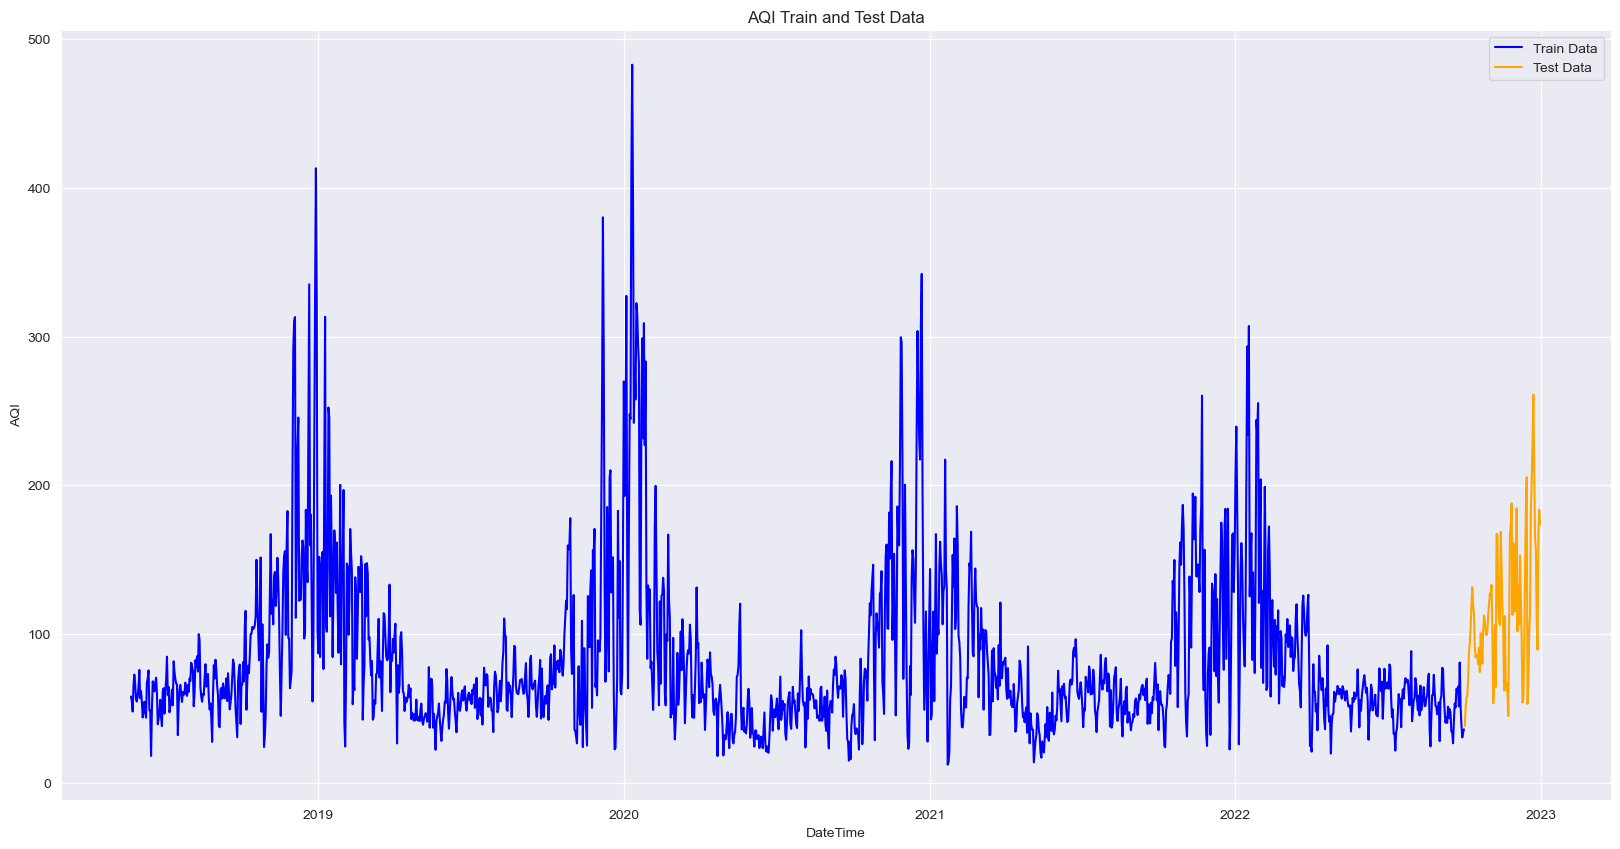

In [33]:
plot_train_test_data(train_data_aqi_ws_ninety, test_data_aqi_ws_ninety, 'DateTime', 'AQI')

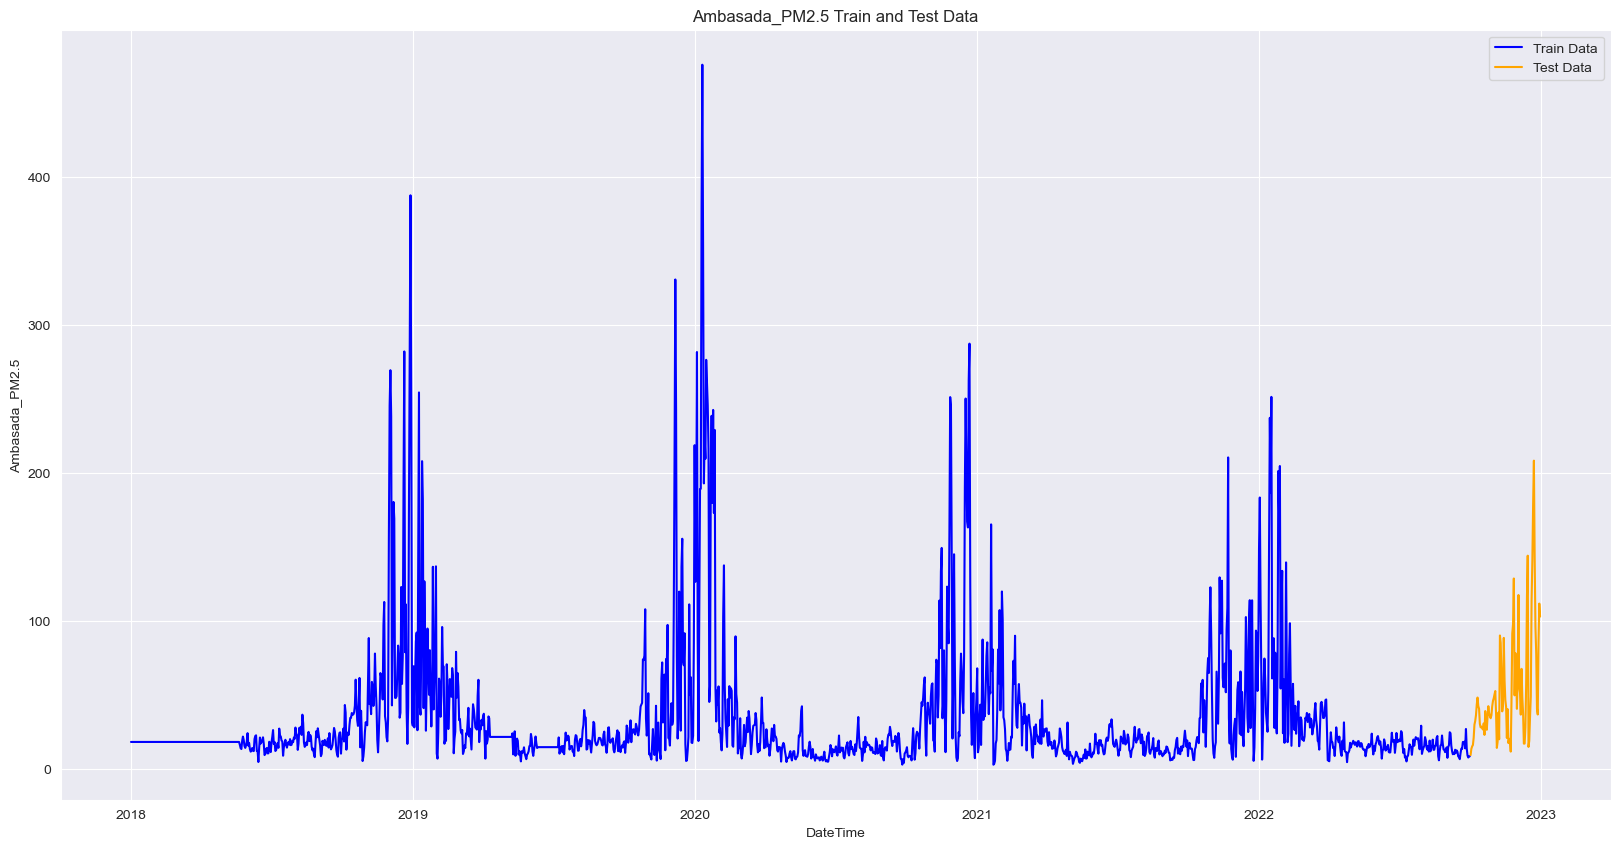

In [34]:
plot_train_test_data(train_data_combined_ws_ninety, test_data_combined_ws_ninety, 'DateTime', 'Ambasada_PM2.5')


# Univariate Time Series Forecasting using FBProphet

In [35]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

def train_prophet(train_data):
    model = Prophet()
    model.fit(train_data)
    return model

def predict_prophet(model, test_data):
    forecast = model.predict(test_data)
    return forecast

def calculate_metrics(test, forecast, true_label='y', predicted_label='yhat'):
    mae = mean_absolute_error(test[true_label], forecast[predicted_label])
    mse = mean_squared_error(test[true_label], forecast[predicted_label])
    rmse = sqrt(mse)  # Ispravno računanje RMSE
    #rmse = sqrt(mae) # ovo provjeri jesi li ispravila
    r2 = r2_score(test[true_label], forecast[predicted_label])
    return rmse, mae, r2

def plot_boxplot(prediction_data, test_data):
    error = abs(prediction_data - test_data)
    # plot boxplot of error
    plt.figure(figsize=(10,6))
    plt.boxplot(error)
    plt.show()

In [36]:
train_data_aqi_ws_sixty.head(2)

DateTime   AQI
0 2018-05-22  58.0
1 2018-05-23  55.0

In [37]:
train_data_aqi_ws_thirty.rename(columns={'DateTime': 'ds', 'AQI': 'y'}, inplace=True)
test_data_aqi_ws_thirty.rename(columns={'DateTime': 'ds', 'AQI': 'y'}, inplace=True)

train_data_aqi_ws_sixty.rename(columns={'DateTime': 'ds', 'AQI': 'y'}, inplace=True)
test_data_aqi_ws_sixty.rename(columns={'DateTime': 'ds', 'AQI': 'y'}, inplace=True)

train_data_aqi_ws_ninety.rename(columns={'DateTime': 'ds', 'AQI': 'y'}, inplace=True)
test_data_aqi_ws_ninety.rename(columns={'DateTime': 'ds', 'AQI': 'y'}, inplace=True)

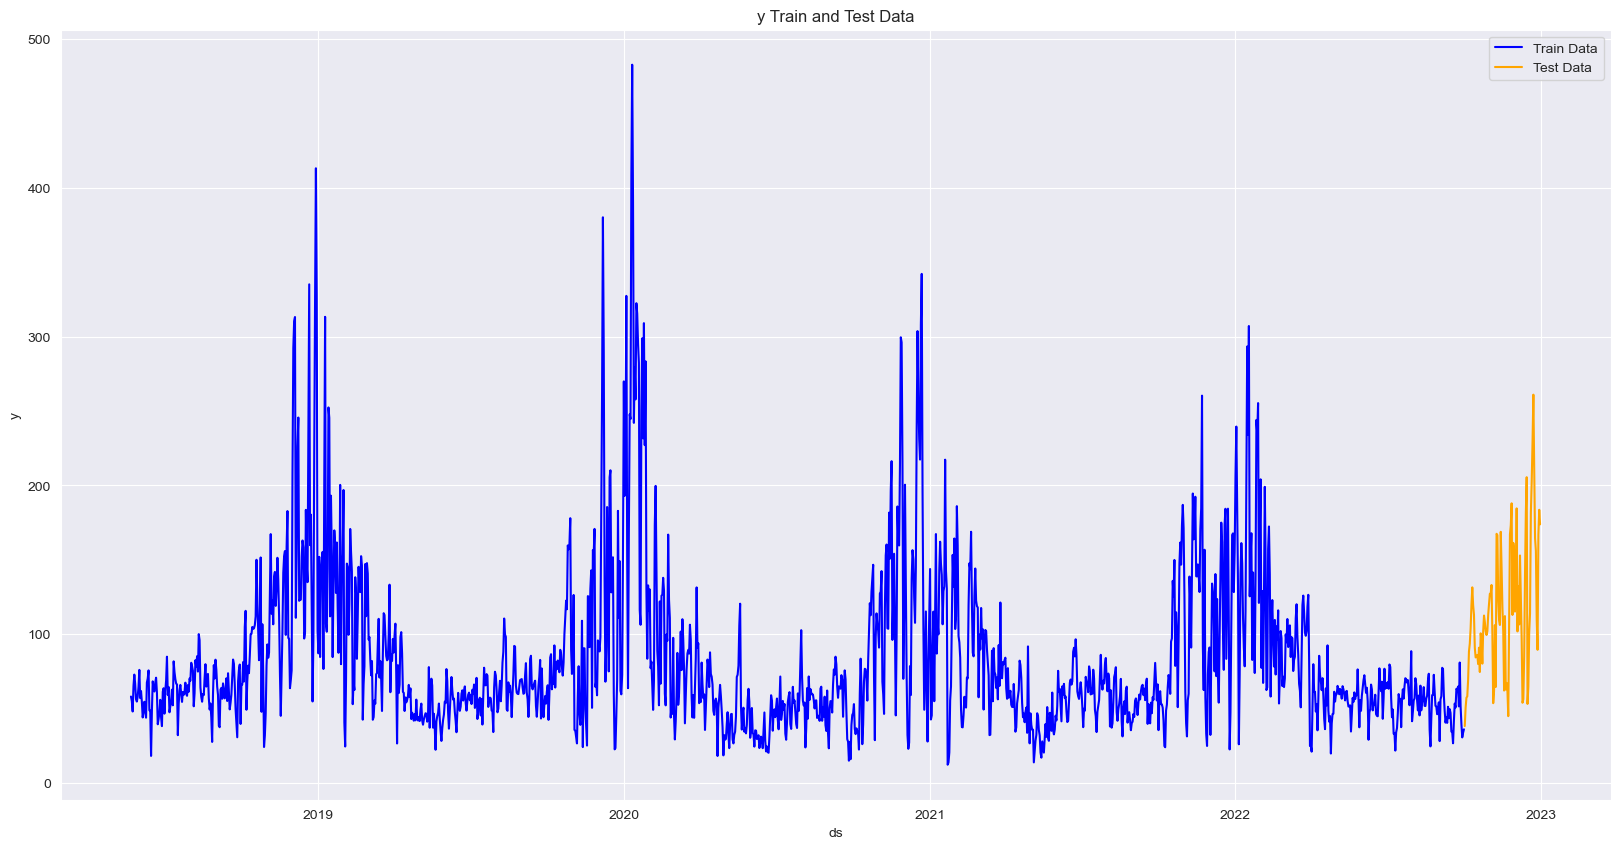

In [38]:
plot_train_test_data(train_data_aqi_ws_ninety, test_data_aqi_ws_ninety, 'ds', 'y')

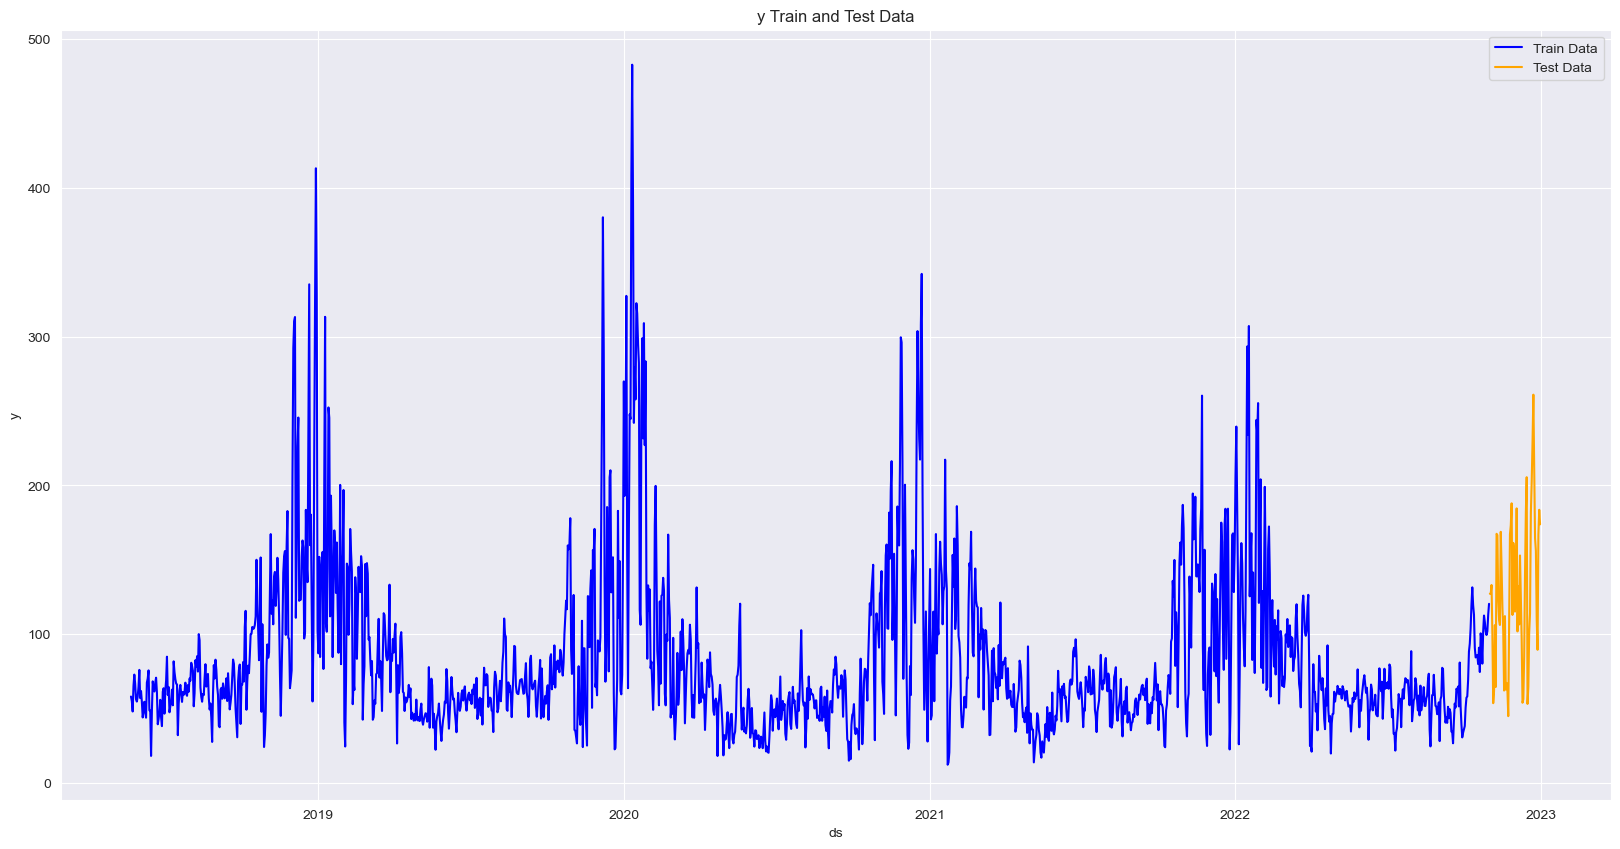

In [39]:
plot_train_test_data(train_data_aqi_ws_sixty, test_data_aqi_ws_sixty, 'ds', 'y')

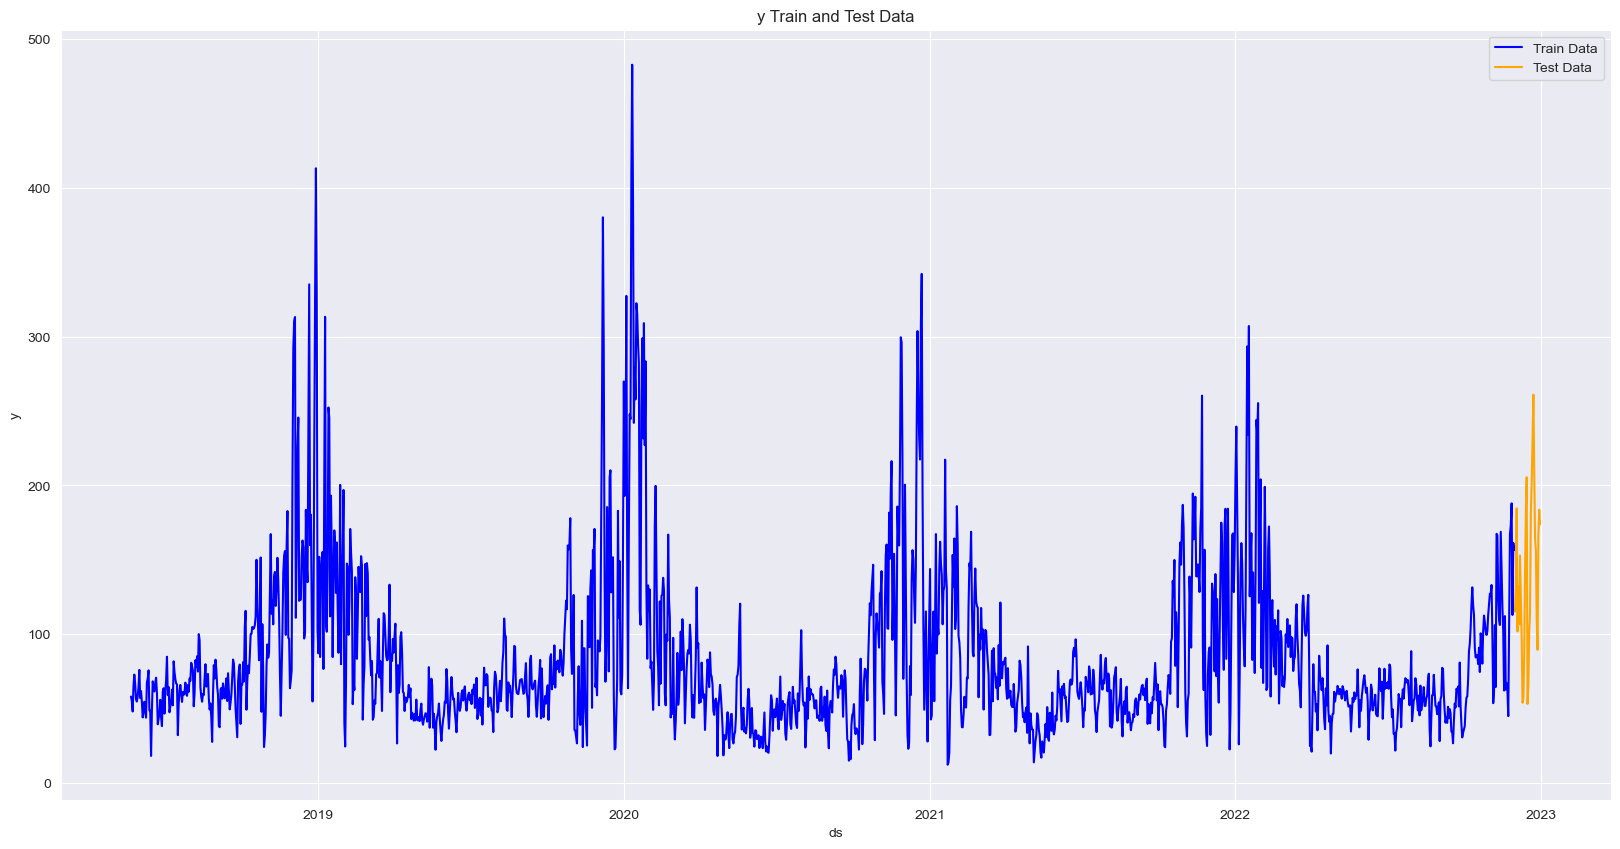

In [40]:
# check if is accidentally changed
plot_train_test_data(train_data_aqi_ws_thirty, test_data_aqi_ws_thirty, 'ds', 'y')

In [41]:
# test_data_aqi_ws_thirty.info()

In [42]:
model_aqi_ws_thirty = train_prophet(train_data_aqi_ws_thirty)
forecast_aqi_ws_thirty = predict_prophet(model_aqi_ws_thirty, test_data_aqi_ws_thirty)
rmse, mae, r2 = calculate_metrics(test_data_aqi_ws_thirty, forecast_aqi_ws_thirty)

print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % mae)
print('R2: %.3f' % r2)


06:25:00 - cmdstanpy - INFO - Chain [1] start processing
06:25:04 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 53.700
MAE: 45.174
R2: -0.016


In [43]:
forecast_aqi_ws_thirty['yhat'].tail(2)

29    154.627928
30    155.014476
Name: yhat, dtype: float64

In [44]:
model_aqi_ws_sixty = train_prophet(train_data_aqi_ws_sixty)
forecast_aqi_ws_sixty = predict_prophet(model_aqi_ws_sixty, test_data_aqi_ws_sixty)
rmse, mae, r2 = calculate_metrics(test_data_aqi_ws_sixty, forecast_aqi_ws_sixty)

print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % mae)
print('R2: %.3f' % r2)


06:25:14 - cmdstanpy - INFO - Chain [1] start processing
06:25:15 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 47.339
MAE: 39.186
R2: 0.074


In [45]:
model_aqi_ws_ninety = train_prophet(train_data_aqi_ws_ninety)
forecast_aqi_ws_ninety = predict_prophet(model_aqi_ws_ninety, test_data_aqi_ws_ninety)
rmse, mae, r2 = calculate_metrics(test_data_aqi_ws_ninety, forecast_aqi_ws_ninety)

print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % mae)
print('R2: %.3f' % r2)

06:25:22 - cmdstanpy - INFO - Chain [1] start processing
06:25:23 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 40.866
MAE: 31.298
R2: 0.188


In [46]:
def plot_forecast(test, forecast, date_col='ds', true_label='y', predicted_label='yhat'):
    plt.figure(figsize=(10,6))
    plt.plot(test[date_col], test[true_label], label='Actual')
    plt.plot(test[date_col], forecast[predicted_label], label='Predicted')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel(true_label)
    plt.title('Actual vs Predicted ' + true_label)
    plt.show()


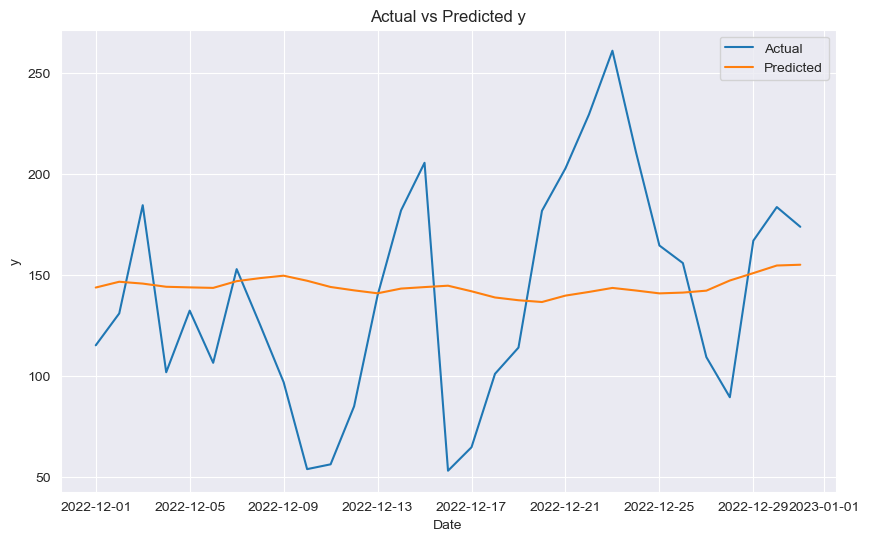

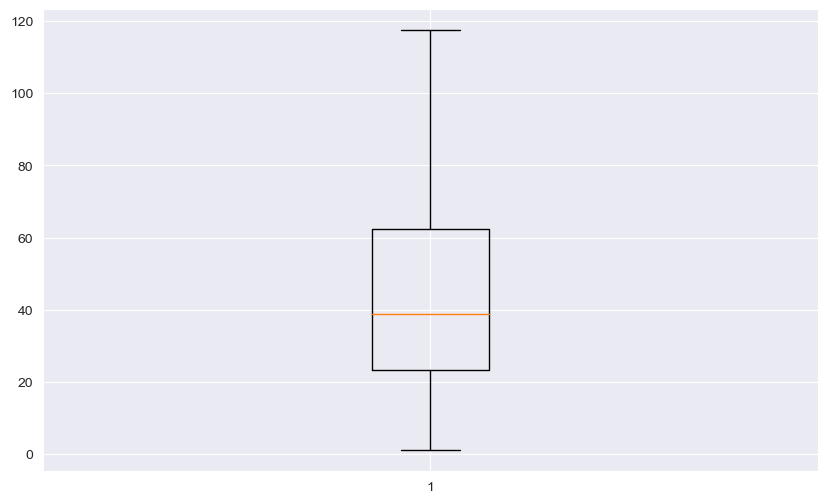

In [47]:
#plot_forecast(test_data_aqi, forecast_aqi)
#plot_boxplot(forecast_aqi['yhat'].values.reshape(-1,1), test_data_aqi['y'].values.reshape(-1,1))
plot_forecast(test_data_aqi_ws_thirty, forecast_aqi_ws_thirty)
plot_boxplot(forecast_aqi_ws_thirty['yhat'].values.reshape(-1,1), test_data_aqi_ws_thirty['y'].values.reshape(-1,1))

#plot_forecast(test_data_aqi_ws_thirty, model_aqi_ws_thirty)
#plot_boxplot(model_aqi_ws_thirty['yhat'].values.reshape(-1,1), test_data_aqi_ws_thirty['y'].values.reshape(-1,1))

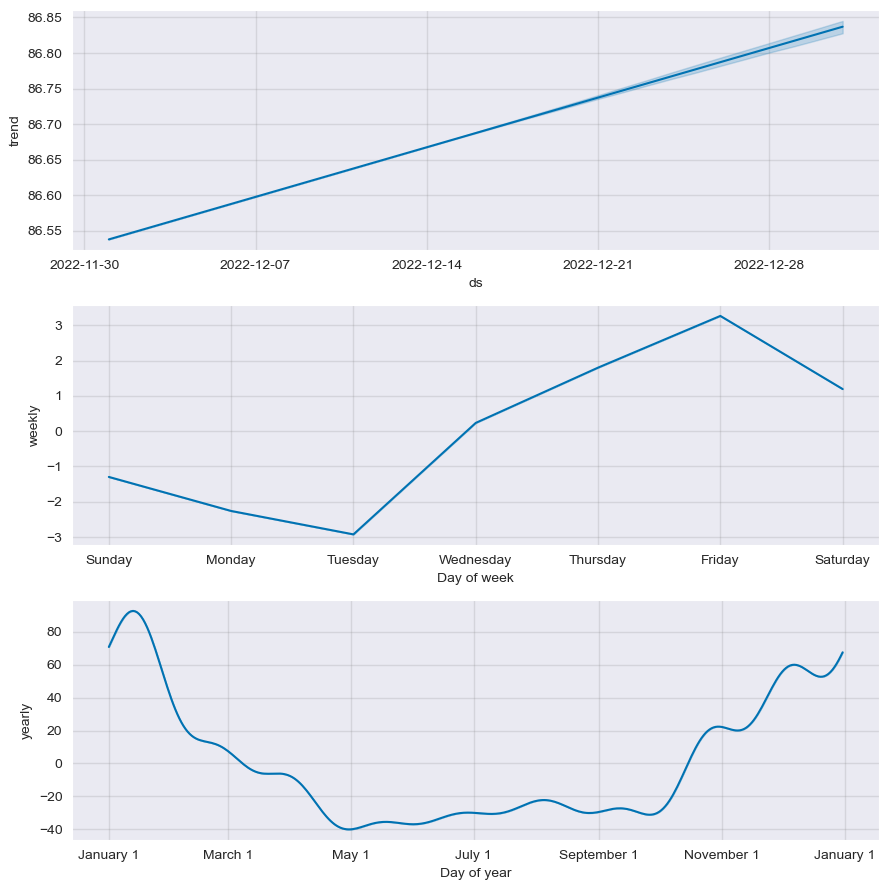

In [48]:
# Visualizing the components of the forecast, such as the trend, yearly seasonality, and weekly seasonality. This can be done using the 'plot_components' method of the Prophet model
model_aqi_ws_thirty.plot_components(forecast_aqi_ws_thirty)
plt.show()

In [51]:
print(forecast_aqi_ws_thirty[['ds', 'yhat', 'trend', 'yearly', 'weekly']].head(2))

          ds        yhat      trend     yearly    weekly
0 2022-12-01  143.724681  86.538110  55.388356  1.798215
1 2022-12-02  146.589672  86.548074  56.778227  3.263371


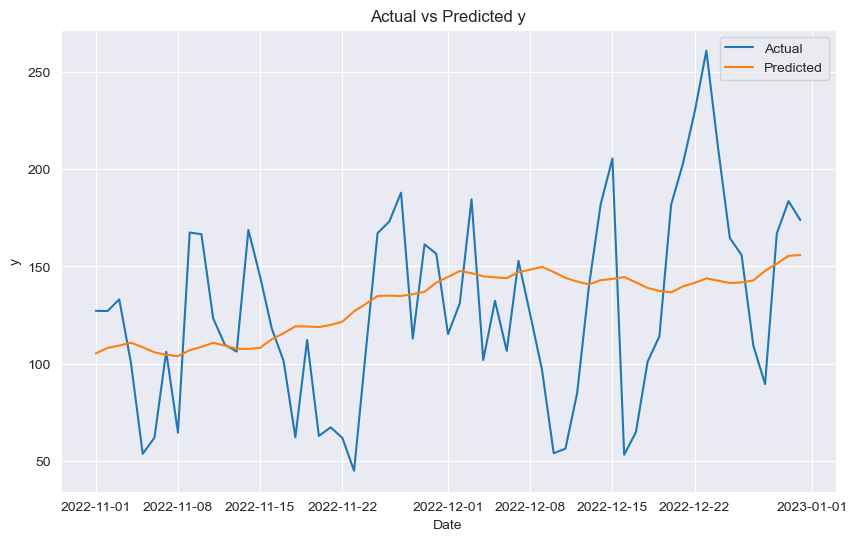

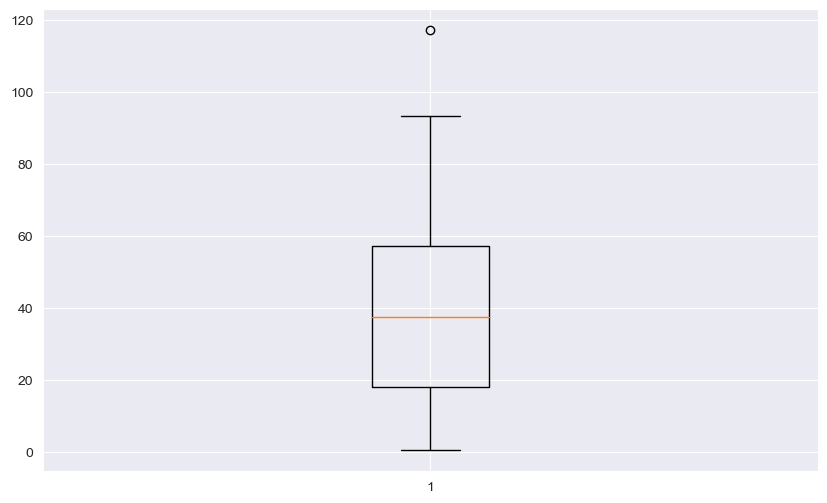

In [53]:
plot_forecast(test_data_aqi_ws_sixty, forecast_aqi_ws_sixty)
plot_boxplot(forecast_aqi_ws_sixty['yhat'].values.reshape(-1,1), test_data_aqi_ws_sixty['y'].values.reshape(-1,1))

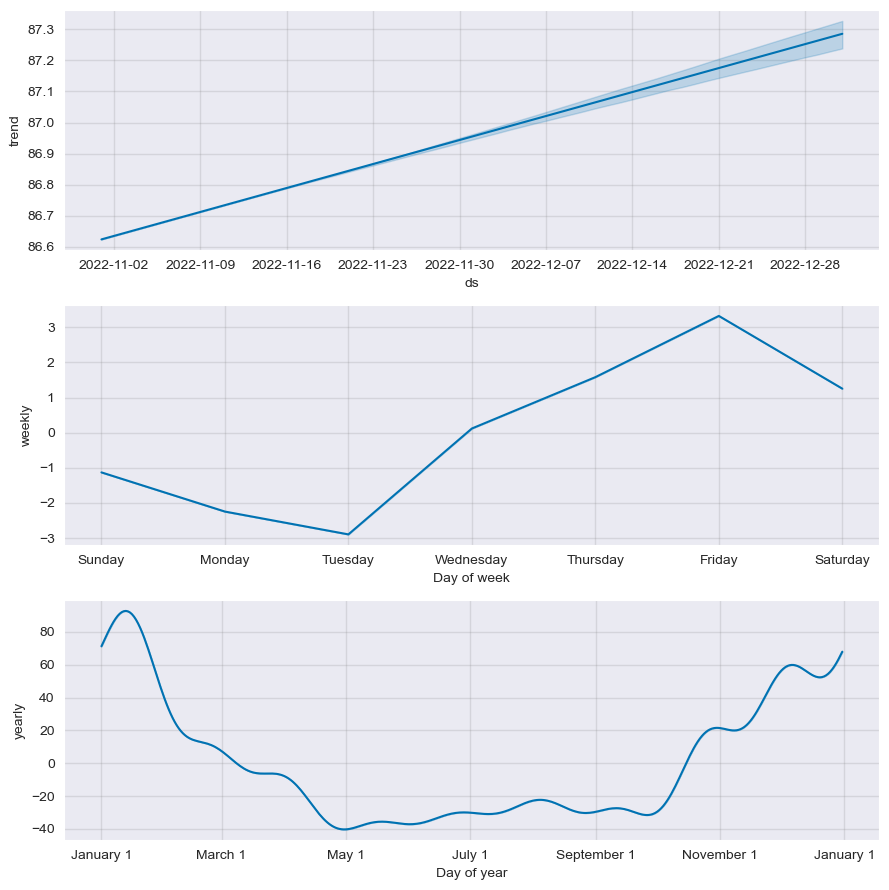

In [54]:
model_aqi_ws_sixty.plot_components(forecast_aqi_ws_sixty)
plt.show()

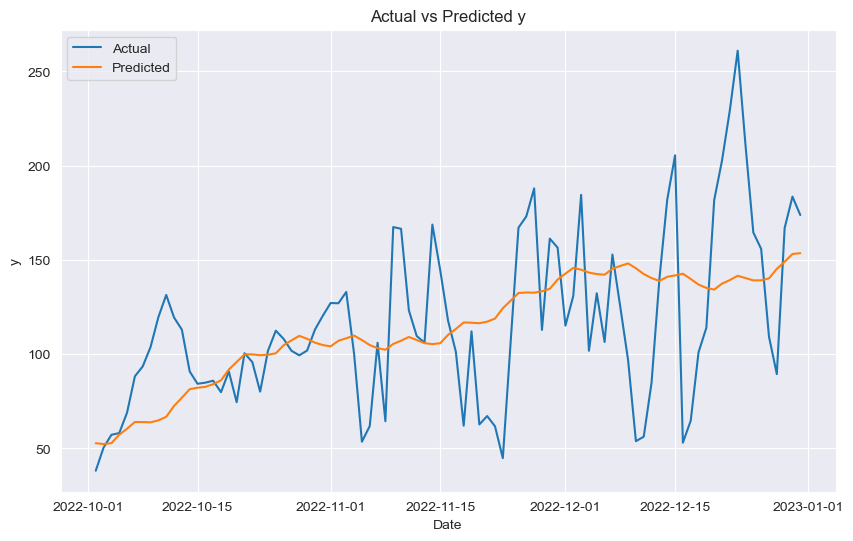

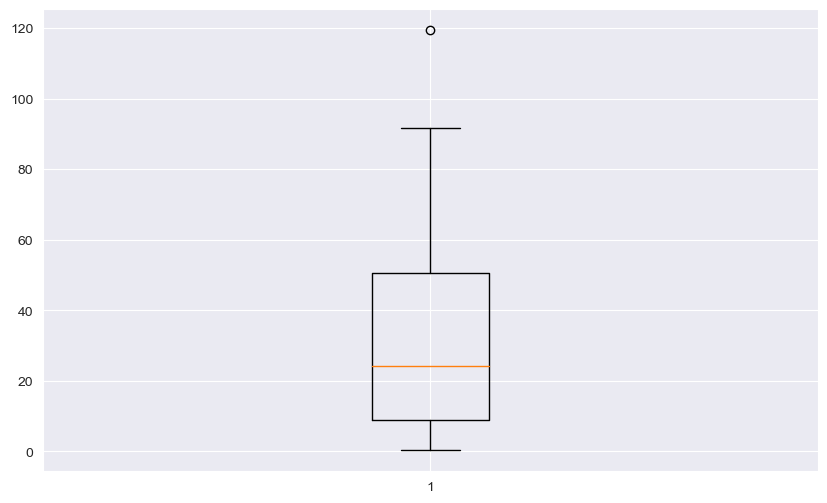

In [55]:
plot_forecast(test_data_aqi_ws_ninety, forecast_aqi_ws_ninety)
plot_boxplot(forecast_aqi_ws_ninety['yhat'].values.reshape(-1,1), test_data_aqi_ws_ninety['y'].values.reshape(-1,1))

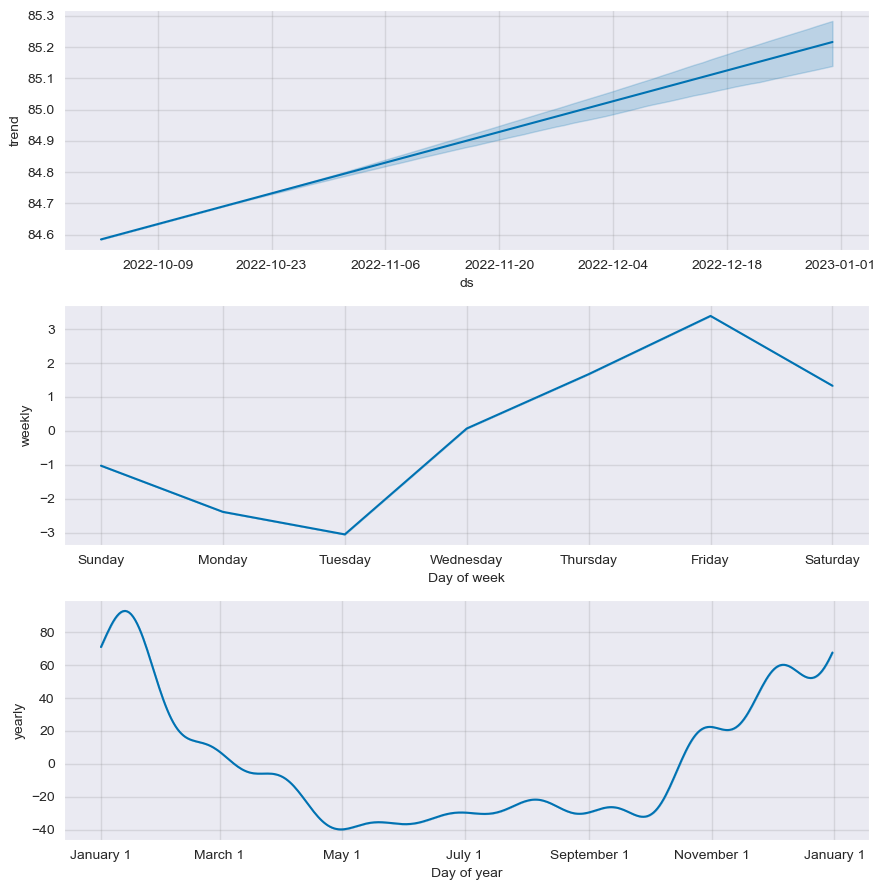

In [56]:
model_aqi_ws_ninety.plot_components(forecast_aqi_ws_ninety)
plt.show()

# Multivariate Time Series Forecasting using FBProphet

In [57]:
train_data_combined_ws_thirty.rename(columns={'DateTime': 'ds', 'Ambasada_PM2.5': 'y'}, inplace=True)
test_data_combined_ws_thirty.rename(columns={'DateTime': 'ds', 'Ambasada_PM2.5': 'y'}, inplace=True)

train_data_combined_ws_sixty.rename(columns={'DateTime': 'ds', 'Ambasada_PM2.5': 'y'}, inplace=True)
test_data_combined_ws_sixty.rename(columns={'DateTime': 'ds', 'Ambasada_PM2.5': 'y'}, inplace=True)

train_data_combined_ws_ninety.rename(columns={'DateTime': 'ds', 'Ambasada_PM2.5': 'y'}, inplace=True)
test_data_combined_ws_ninety.rename(columns={'DateTime': 'ds', 'Ambasada_PM2.5': 'y'}, inplace=True)

In [58]:
def train_prophet_multivariate(train_data):
    model = Prophet()
    #added
    model.add_regressor('wind_speed')
    model.add_regressor('wind_direction')
    model.add_regressor('precipitation')
    model.add_regressor('pressure')
    model.add_regressor('temperature')
    model.add_regressor('humidity')
    model.add_regressor('visibility')
    model.add_regressor('cloudiness')
    model.add_regressor('Bjelave_PM10')
    model.add_regressor('Bjelave_SO2')
    model.add_regressor('Bjelave_NO2')
    #added
    model.fit(train_data)
    return model

In [59]:
model_combined_ws_thirty = train_prophet_multivariate(train_data_combined_ws_thirty)
forecast_combined_ws_thirty = predict_prophet(model_combined_ws_thirty, test_data_combined_ws_thirty)
rmse, mae, r2 = calculate_metrics(test_data_combined_ws_thirty, forecast_combined_ws_thirty)

print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % mae)
print('R2: %.3f' % r2)

06:26:53 - cmdstanpy - INFO - Chain [1] start processing
06:26:54 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 20.083
MAE: 18.353
R2: 0.837


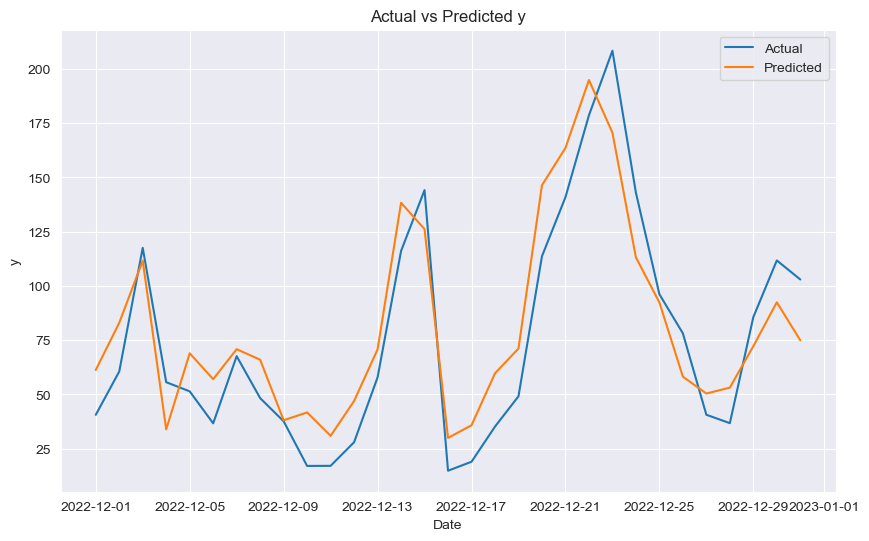

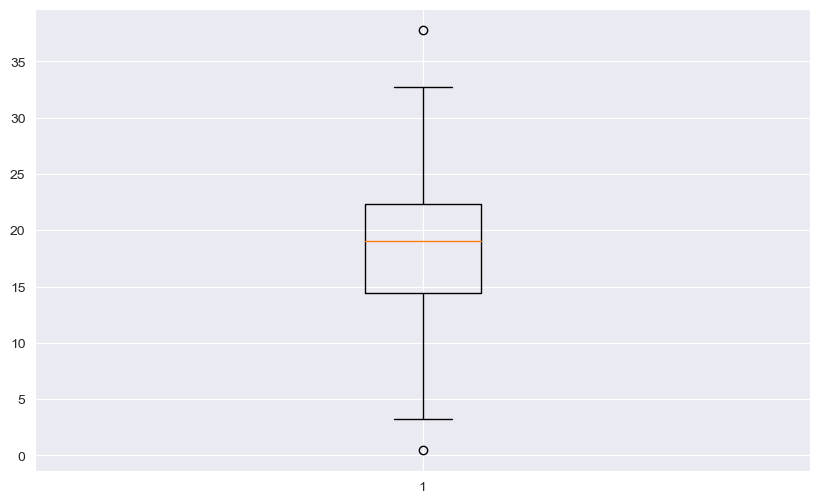

In [60]:
plot_forecast(test_data_combined_ws_thirty, forecast_combined_ws_thirty)
plot_boxplot(forecast_combined_ws_thirty['yhat'].values.reshape(-1,1), test_data_combined_ws_thirty['y'].values.reshape(-1,1))

In [61]:
forecast_combined_ws_thirty.tail(1)

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
30 2022-12-31  37.997834   51.784668   96.434619    37.879615    38.116522   

    Bjelave_NO2  Bjelave_NO2_lower  Bjelave_NO2_upper  Bjelave_PM10  ...  \
30     3.534364           3.534364           3.534364      8.046571  ...   

    wind_speed  wind_speed_lower  wind_speed_upper     yearly  yearly_lower  \
30   -0.679675         -0.679675         -0.679675  18.617605     18.617605   

    yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
30     18.617605                   0.0                         0.0   

    multiplicative_terms_upper       yhat  
30                         0.0  74.902109  

[1 rows x 55 columns]

In [62]:
forecast_aqi_ws_thirty.tail(1)


ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
30 2022-12-31  86.837025   104.18229  204.199454    86.827814     86.84516   

    additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
30       68.177452             68.177452             68.177452  1.191827   

    weekly_lower  weekly_upper     yearly  yearly_lower  yearly_upper  \
30      1.191827      1.191827  66.985624     66.985624     66.985624   

    multiplicative_terms  multiplicative_terms_lower  \
30                   0.0                         0.0   

    multiplicative_terms_upper        yhat  
30                         0.0  155.014476

In [63]:
model_combined_ws_sixty = train_prophet_multivariate(train_data_combined_ws_sixty)
forecast_combined_ws_sixty = predict_prophet(model_combined_ws_sixty, test_data_combined_ws_sixty)
rmse, mae, r2 = calculate_metrics(test_data_combined_ws_sixty, forecast_combined_ws_sixty)

print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % mae)
print('R2: %.3f' % r2)

06:27:10 - cmdstanpy - INFO - Chain [1] start processing
06:27:11 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 17.490
MAE: 15.306
R2: 0.832


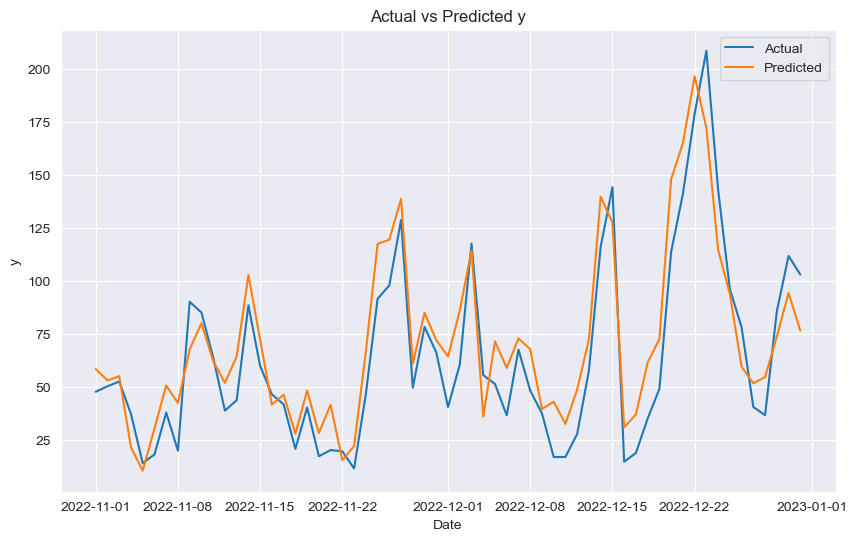

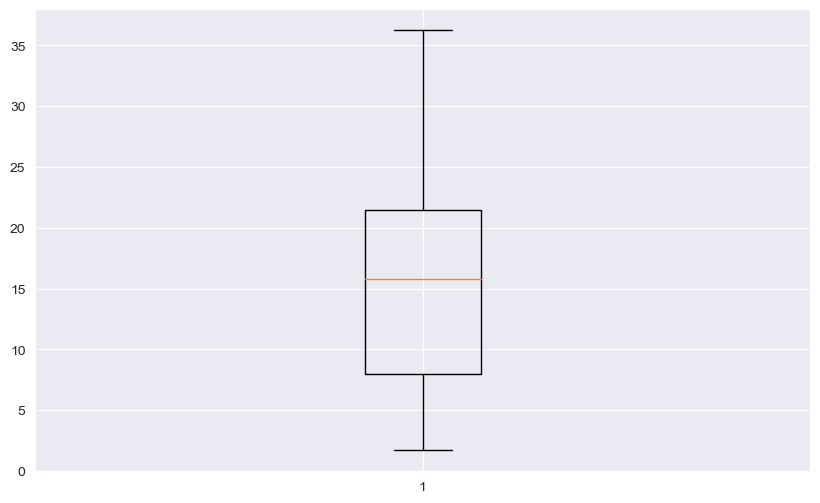

In [64]:
plot_forecast(test_data_combined_ws_sixty, forecast_combined_ws_sixty)
plot_boxplot(forecast_combined_ws_sixty['yhat'].values.reshape(-1,1), test_data_combined_ws_sixty['y'].values.reshape(-1,1))

In [65]:
model_combined_ws_ninety = train_prophet_multivariate(train_data_combined_ws_ninety)
forecast_combined_ws_ninety = predict_prophet(model_combined_ws_ninety, test_data_combined_ws_ninety)
rmse, mae, r2 = calculate_metrics(test_data_combined_ws_ninety, forecast_combined_ws_ninety)

print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % mae)
print('R2: %.3f' % r2)

06:27:20 - cmdstanpy - INFO - Chain [1] start processing
06:27:21 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 17.649
MAE: 15.135
R2: 0.789


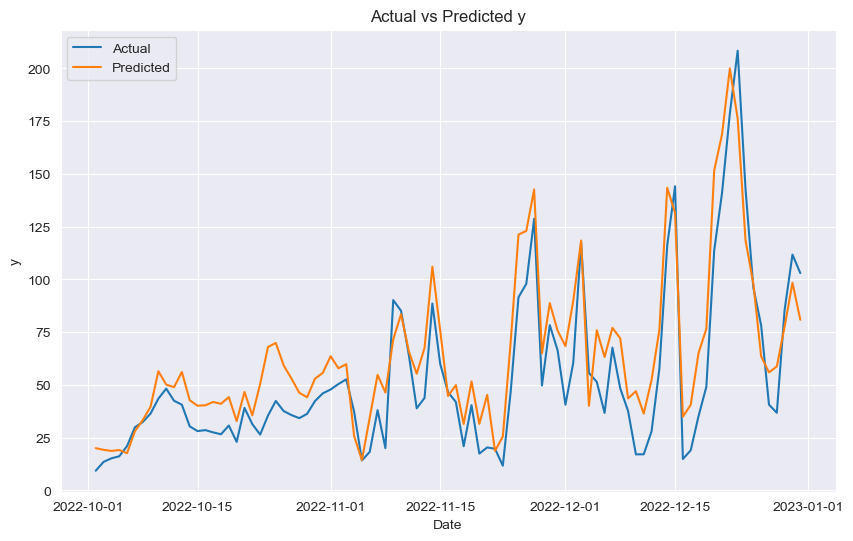

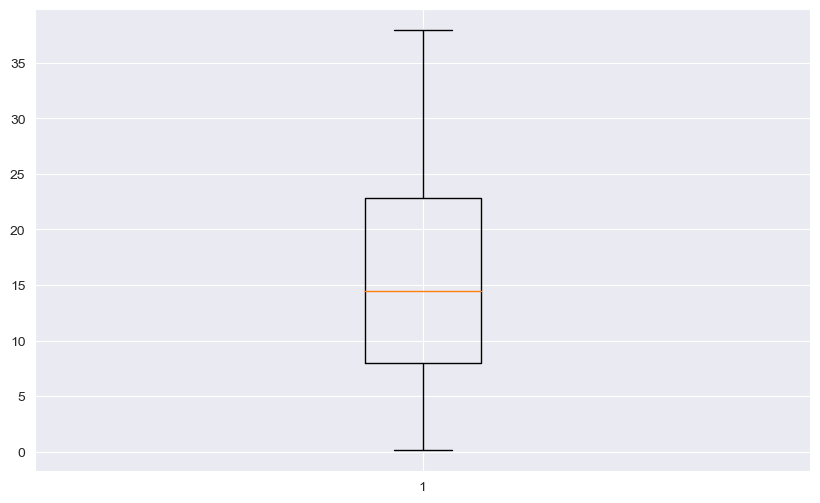

In [66]:
plot_forecast(test_data_combined_ws_ninety, forecast_combined_ws_ninety)
plot_boxplot(forecast_combined_ws_ninety['yhat'].values.reshape(-1,1), test_data_combined_ws_ninety['y'].values.reshape(-1,1))

In [67]:
test_data_combined_ws_ninety

ds           y  wind_speed  wind_direction  precipitation  \
1735 2022-10-02    9.291667    1.170833      183.583333       0.000000   
1736 2022-10-03   13.500000    1.441667      165.916667       0.112500   
1737 2022-10-04   15.173913    1.050000      178.666667       0.000000   
1738 2022-10-05   16.125000    2.125000      168.666667       0.000000   
1739 2022-10-06   21.000000    2.300000      173.625000       0.000000   
...         ...         ...         ...             ...            ...   
1821 2022-12-27   40.625000    2.029167      125.375000       0.479167   
1822 2022-12-28   36.750000    1.450000      179.125000       0.000000   
1823 2022-12-29   85.625000    2.187500      146.166667       0.000000   
1824 2022-12-30  111.739130    1.070833      159.541667       0.000000   
1825 2022-12-31  102.958333    2.050000      128.875000       0.000000   

        pressure  temperature   humidity    visibility  cloudiness  \
1735  945.766667    13.912500  74.916667  15295.833333    3.600000   
1736  945.950000    11.783333  74.041667  15495.833333    4.487500   
1737  949.695833     9.804167  73.458333  18229.166667    4.679167   
1738  953.529167    10.745833  68.541667  18941.666667    4.241667   
1739  954.479167    11.887500  63.250000  19766.666667    3.837500   
...          ...          ...        ...           ...         ...   
1821  948.729167     7.879167  79.666667  18579.166667    6.358333   
1822  949.583333     4.591667  82.208333  19416.666667    4.937500   
1823  947.341667     5.354167  81.666667  18812.500000    4.187500   
1824  947.279167     6.429167  79.083333  19416.666667    4.000000   
1825  952.166667     6.670833  77.708333  18812.500000    2.775000   

      Bjelave_PM10  Bjelave_SO2  Bjelave_NO2  
1735     13.042623     8.410982    10.415785  
1736     13.615046     8.415295    11.958691  
1737     15.149664     9.726041    14.787614  
1738     18.742900     9.213005    14.951653  
1739     20.770045    15.636859    17.208139  
...            ...          ...          ...  
1821     26.714598    22.752038    26.175499  
1822     29.372987    23.098171    32.184576  
1823     50.187371    25.431842    38.493039  
1824     67.841704    27.591008    54.974991  
1825     48.536400    24.678667    32.047637  

[91 rows x 13 columns]

# Prerequisites and Data Preparation for SHAP Analysis of Facebook Prophet Models

In [68]:
len(train_data_aqi_ws_thirty)/6

275.6666666666667

In [69]:
import shap
#num_samples=int(len(train_data_aqi_ws_thirty)/6)
num_samples=100
len_train_data=len(train_data_aqi_ws_thirty) #int(len(train_data_aqi_ws_thirty)/5)
background_data_aqi_ws_thirty = shap.sample(train_data_aqi_ws_thirty, num_samples)
background_data_aqi_ws_sixty = shap.sample(train_data_aqi_ws_sixty, num_samples)
background_data_aqi_ws_ninety = shap.sample(train_data_aqi_ws_ninety, num_samples)

background_data_combined_ws_thirty = shap.sample(train_data_combined_ws_thirty, num_samples)
background_data_combined_ws_sixty= shap.sample(train_data_combined_ws_sixty, num_samples)
background_data_combined_ws_ninety = shap.sample(train_data_combined_ws_ninety, num_samples)

print("len(background_data_ws_aqi_thirty): ", len(background_data_aqi_ws_thirty))
print("len(background_data_combined_ws_thirty): ", len(background_data_combined_ws_thirty))
print("len(train_data_aqi_ws_thirty): ", len(train_data_aqi_ws_thirty))

print("\nlen(background_data_aqi_ws_sixty): ", len(background_data_aqi_ws_sixty))
print("len(background_data_combined_ws_sixty): ", len(background_data_combined_ws_sixty))
print("len(train_data_aqi_ws_sixty): ", len(train_data_aqi_ws_sixty))

print("\nlen(background_data_aqi_ws_ninety): ", len(background_data_aqi_ws_ninety))
print("len(background_data_combined_ws_ninety): ", len(background_data_combined_ws_ninety))
print("len(train_data_aqi_ws_ninety): ", len(train_data_aqi_ws_ninety))

len(background_data_ws_aqi_thirty):  100
len(background_data_combined_ws_thirty):  100
len(train_data_aqi_ws_thirty):  1654

len(background_data_aqi_ws_sixty):  100
len(background_data_combined_ws_sixty):  100
len(train_data_aqi_ws_sixty):  1624

len(background_data_aqi_ws_ninety):  100
len(background_data_combined_ws_ninety):  100
len(train_data_aqi_ws_ninety):  1594


In [70]:
background_data_aqi_ws_ninety.tail(1)

ds           y
249 2019-01-26  113.666667

In [70]:
background_data_combined_ws_ninety.tail(1)

ds          y  wind_speed  wind_direction  precipitation  \
1288 2021-07-12  16.458333       1.575      202.833333            0.0   

      pressure  temperature   humidity  visibility  cloudiness  Bjelave_PM10  \
1288  941.7375    23.816667  58.041667     19525.0         0.7     29.514776   

      Bjelave_SO2  Bjelave_NO2  
1288    14.762154    15.139171

In [71]:
feature_columns_combined=['ds',
 'y',
 'wind_speed',
 'wind_direction',
 'precipitation',
 'pressure',
 'temperature',
 'humidity',
 'visibility',
 'cloudiness',
 'Bjelave_PM10',
 'Bjelave_SO2',
 'Bjelave_NO2']
feature_columns_aqi=['ds',
                     'y']

In [73]:
def prophet_predict_ws_thirty_for_shap(data_df):
    if not isinstance(data_df, pd.DataFrame):
         data_df = pd.DataFrame(data_df, columns=feature_columns_aqi)
         print(" -> len(data_df): ", len(data_df))
         print(" -> type(data_df): ", type(data_df))
    predictions = model_aqi_ws_thirty.predict(data_df)
    return predictions['yhat'].values # Vrati samo yhat kao NumPy array


def prophet_predict_ws_sixty_for_shap(data_df):
    if not isinstance(data_df, pd.DataFrame):
         data_df = pd.DataFrame(data_df, columns=feature_columns_aqi)
    predictions = model_aqi_ws_sixty.predict(data_df)
    return predictions['yhat'].values


def prophet_predict_ws_ninety_for_shap(data_df):
    if not isinstance(data_df, pd.DataFrame):
         data_df = pd.DataFrame(data_df, columns=feature_columns_aqi)
    predictions = model_aqi_ws_ninety.predict(data_df)
    return predictions['yhat'].values

In [74]:
def prophet_predict_ws_thirty_for_shap_combined(data_df):
    if not isinstance(data_df, pd.DataFrame):
         data_df = pd.DataFrame(data_df, columns=feature_columns_combined)
         print(" -> len(data_df): ", len(data_df))
         print(" -> type(data_df): ", type(data_df))
    predictions = model_combined_ws_thirty.predict(data_df)
    return predictions['yhat'].values # Vrati samo yhat kao NumPy array


def prophet_predict_ws_sixty_for_shap_combined(data_df):
    if not isinstance(data_df, pd.DataFrame):
         data_df = pd.DataFrame(data_df, columns=feature_columns_combined)
    predictions = model_combined_ws_sixty.predict(data_df)
    return predictions['yhat'].values


def prophet_predict_ws_ninety_for_shap_combined(data_df):
    if not isinstance(data_df, pd.DataFrame):
         data_df = pd.DataFrame(data_df, columns=feature_columns_combined)
    predictions = model_combined_ws_ninety.predict(data_df)
    return predictions['yhat'].values

In [75]:
train_data_aqi_ws_thirty.tail(1)

ds      y
1653 2022-11-30  156.5

In [76]:
#train_data_aqi_ws_sixty.rename(columns={'DateTime': 'ds', 'Ambasada_PM2.5': 'y'}, inplace=True)\
data_aqi_to_explain_ws_thirty=test_data_aqi_ws_thirty.rename(columns={'y': 'yhat'})
data_aqi_to_explain_ws_sixty=test_data_aqi_ws_sixty.rename(columns={'y': 'yhat'})
data_aqi_to_explain_ws_ninety=test_data_aqi_ws_ninety.rename(columns={'y': 'yhat'})

day_aqi_to_explain_ws_thirty=test_data_aqi_ws_thirty.rename(columns={'y': 'yhat'}).tail(1)
day_aqi_to_explain_ws_sixty=test_data_aqi_ws_sixty.rename(columns={'y': 'yhat'}).tail(1)
day_aqi_to_explain_ws_ninety=test_data_aqi_ws_ninety.rename(columns={'y': 'yhat'}).tail(1)


In [77]:
data_combined_to_explain_ws_thirty=test_data_combined_ws_thirty.rename(columns={'y': 'yhat'})
data_combined_to_explain_ws_sixty=test_data_combined_ws_sixty.rename(columns={'y': 'yhat'})
data_combined_to_explain_ws_ninety=test_data_combined_ws_ninety.rename(columns={'y': 'yhat'})

day_combined_to_explain_ws_thirty=test_data_combined_ws_thirty.rename(columns={'y': 'yhat'}).tail(1)
day_combined_to_explain_ws_sixty=test_data_combined_ws_sixty.rename(columns={'y': 'yhat'}).tail(1)
day_combined_to_explain_ws_ninety=test_data_combined_ws_ninety.rename(columns={'y': 'yhat'}).tail(1)


In [78]:
day_aqi_to_explain_ws_thirty

ds        yhat
1684 2022-12-31  173.791667

In [79]:
print("len(data_aqi_to_explain_ws_sixty)", len(data_aqi_to_explain_ws_sixty))
print("len(data_combined_to_explain_ws_sixty)", len(data_combined_to_explain_ws_sixty))

print("len(background_data_aqi_ws_sixty)", len(background_data_aqi_ws_sixty))

len(data_aqi_to_explain_ws_sixty) 61
len(data_combined_to_explain_ws_sixty) 61
len(background_data_aqi_ws_sixty) 100


**SHAP plots for shap_values_ws_thirty**

In [79]:
#base_value_for_explanation_ws_thirty = explainer_ws_thirty.expected_value
#raw_shap_values_ws_thirty = explainer_ws_thirty.shap_values(data_to_explain_ws_thirty)

#explainer_ws_thirty = shap.KernelExplainer(prophet_predict_ws_thirty_for_shap, background_data_ws_thirty)
#shap_values_ws_thirty = explainer_ws_thirty.shap_values(data_to_explain_ws_thirty)
'''
base_value_for_explanation_ws_thirty = explainer_ws_thirty.expected_value

if isinstance(shap_values_ws_thirty, np.ndarray) and isinstance(base_value_for_explanation_ws_thirty, (float, np.float_)):
    explanation_ws_thirty = shap.Explanation(
        values=shap_values_ws_thirty,
        base_values=np.array([base_value_for_explanation_ws_thirty]), # Skalarna vrijednost
        data=data_to_explain_ws_thirty, # Vaš originalni DataFrame/array
        #feature_names=data_to_explain_ws_thirty.columns.tolist() if hasattr(data_to_explain_ws_thirty, 'columns') else None
        feature_names=feature_columns
    )
    plt.figure(figsize=(10,8)) # Opcionalno

    #print(shap_values_ws_thirty)
    shap.plots.bar(explanation_ws_thirty, show=False)
#shap.plots.bar(shap_values_ws_thirty)
'''

"\nbase_value_for_explanation_ws_thirty = explainer_ws_thirty.expected_value\n\nif isinstance(shap_values_ws_thirty, np.ndarray) and isinstance(base_value_for_explanation_ws_thirty, (float, np.float_)):\n    explanation_ws_thirty = shap.Explanation(\n        values=shap_values_ws_thirty,\n        base_values=np.array([base_value_for_explanation_ws_thirty]), # Skalarna vrijednost\n        data=data_to_explain_ws_thirty, # Vaš originalni DataFrame/array\n        #feature_names=data_to_explain_ws_thirty.columns.tolist() if hasattr(data_to_explain_ws_thirty, 'columns') else None\n        feature_names=feature_columns\n    )\n    plt.figure(figsize=(10,8)) # Opcionalno\n\n    #print(shap_values_ws_thirty)\n    shap.plots.bar(explanation_ws_thirty, show=False)\n#shap.plots.bar(shap_values_ws_thirty)\n"

In [80]:
#shap.plots.beeswarm(explanation_ws_thirty)
#important relationhips

SHAP interaction effects plot of Ambasada_PM2.5 (30 days)

In [81]:
#The horizontal axis represents the value of the variable, and the shaded area represents the data distribution for this variable.
#The left vertical axis represents the SHAP value, and the right vertical axis displays the variable with which the variable had the
#most-obvious interactions, representing the smallest to the largest of its values by transitioning from blue to red.

#feature_columns = ['ds', 'yhat','wind_speed', 'wind_direction', 'precipitation', 'pressure', 'temperature', 'humidity', 'visibility', 'cloudiness', 'Bjelave_PM10', 'Bjelave_SO2', 'Bjelave_NO2']


In [82]:
#shap.plots.scatter(explanation_ws_thirty[:, 'ds'], color=explanation_ws_thirty[:, 'ds'].data.values)


In [83]:
#shap.plots.scatter(explanation_ws_thirty[:, 'ds']) ne moze ovako
#shap.plots.scatter(explanation_ws_thirty[:, 'ds'].values, explanation_ws_thirty[:, 'ds'].data)
# explanation_ws_thirty[:, 'ds'] je i dalje Explanation objekt, ali samo za značajku 'ds'
#shap.plots.scatter(explainer_ws_thirty)
#type(explanation_ws_thirty[:, 'ds'].data.values)

In [84]:
#shap.plots.scatter(shap_values_ws_thirty[:, "yhat"])

In [85]:
#shap.plots.scatter(shap_values_ws_thirty[:, "yhat"])

**SHAP plots for shap_values_ws_sixty**

In [86]:
#shap.summary_plot(shap_values_ws_sixty, forecast_aqi_ws_sixty[feature_columns])

In [87]:
#shap.summary_plot(shap_values_ws_sixty, feature_names=feature_columns, plot_type='bar')

In [88]:
#shap.plots.bar(shap_values_ws_sixty)

In [89]:
#shap.plots.beeswarm(shap_values_ws_sixty)

SHAP interaction effects plot of Ambasada_PM2.5 (60 days)

In [90]:
#shap.plots.scatter(shap_values_ws_sixty[:, "ds"])

In [91]:
#shap.plots.scatter(shap_values_ws_sixty[:, "yhat"])

**SHAP plots for shap_values_ws_ninety**

In [92]:
#shap.summary_plot(shap_values_ws_ninety, forecast_aqi_ws_ninety[feature_columns])

In [93]:
#shap.summary_plot(shap_values_ws_ninety, feature_names=feature_columns, plot_type='bar')

In [94]:
#shap.plots.bar(shap_values_ws_ninety)

In [95]:
#shap.plots.beeswarm(shap_values_ws_ninety)

In [96]:
#shap.summary_plot(shap_values_ws_ninety, feature_names=feature_columns, plot_type='bar', show=False)

SHAP interaction effects plot of Ambasada_PM2.5 (90 days)

In [97]:
#shap.plots.scatter(shap_values_ws_ninety[:, "ds"])

In [98]:
#shap.plots.scatter(shap_values_ws_ninety[:, "yhat"])

# SHAP Analysis of Selected Prediction Days in Facebook Prophet Model

In [80]:
print("type(background_data_aqi_ws_thirty)", type(background_data_aqi_ws_thirty))
print("type(day_aqi_to_explain_ws_thirty)", type(day_aqi_to_explain_ws_thirty))


type(background_data_aqi_ws_thirty) <class 'pandas.core.frame.DataFrame'>
type(day_aqi_to_explain_ws_thirty) <class 'pandas.core.frame.DataFrame'>


In [81]:
day_combined_to_explain_ws_thirty

ds        yhat  wind_speed  wind_direction  precipitation  \
1825 2022-12-31  102.958333        2.05         128.875            0.0   

        pressure  temperature   humidity  visibility  cloudiness  \
1825  952.166667     6.670833  77.708333     18812.5       2.775   

      Bjelave_PM10  Bjelave_SO2  Bjelave_NO2  
1825       48.5364    24.678667    32.047637

In [82]:
prophet_predict_ws_thirty_for_shap

<function __main__.prophet_predict_ws_thirty_for_shap(data_df)>

In [83]:
import shap
explainer_day_aqi_ws_thirty = shap.KernelExplainer(prophet_predict_ws_thirty_for_shap, background_data_aqi_ws_thirty)
shap_values_day_aqi_ws_thirty = explainer_day_aqi_ws_thirty.shap_values(day_aqi_to_explain_ws_thirty)

 -> len(data_df):  100
 -> type(data_df):  <class 'pandas.core.frame.DataFrame'>


  0%|          | 0/1 [00:00<?, ?it/s]

 -> len(data_df):  1
 -> type(data_df):  <class 'pandas.core.frame.DataFrame'>
 -> len(data_df):  200
 -> type(data_df):  <class 'pandas.core.frame.DataFrame'>


In [122]:
forecast_aqi_ws_thirty[['ds', 'yhat']].tail(1)

ds        yhat
30 2022-12-31  155.014476

In [118]:
shap_values_day_aqi_ws_thirty

array([[ 0.        , 71.02424638]])

In [121]:
print(shap_values_day_aqi_ws_thirty.shape)
print(forecast_aqi_ws_thirty[['ds', 'yhat']].shape)


(1, 2)
(31, 2)


In [128]:
print(shap_values_day_aqi_ws_thirty.shape)
print(forecast_aqi_ws_thirty[['ds', 'yhat']].iloc[[30]])

(1, 2)
           ds        yhat
30 2022-12-31  155.014476


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


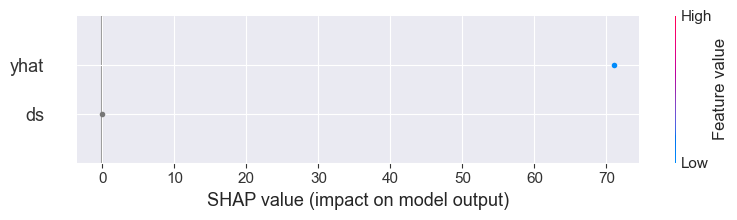

In [129]:
shap.summary_plot(shap_values_day_aqi_ws_thirty, forecast_aqi_ws_thirty[['ds', 'yhat']].iloc[[30]])


In [98]:
print(feature_columns_aqi)
print(day_aqi_to_explain_ws_thirty)

['ds', 'y']
             ds        yhat
1684 2022-12-31  173.791667


In [85]:
explainer_day_aqi_ws_sixty = shap.KernelExplainer(prophet_predict_ws_sixty_for_shap, background_data_aqi_ws_sixty)
shap_values_day_aqi_ws_sixty = explainer_day_aqi_ws_thirty.shap_values(day_aqi_to_explain_ws_sixty)

  0%|          | 0/1 [00:00<?, ?it/s]

 -> len(data_df):  1
 -> type(data_df):  <class 'pandas.core.frame.DataFrame'>
 -> len(data_df):  200
 -> type(data_df):  <class 'pandas.core.frame.DataFrame'>


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


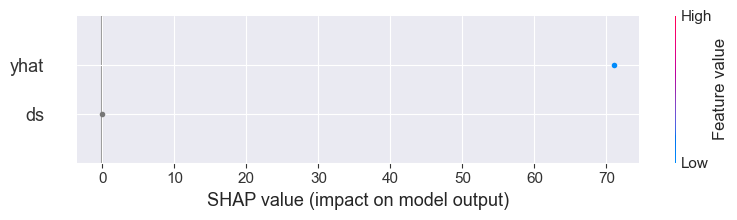

In [130]:
shap.summary_plot(shap_values_day_aqi_ws_sixty, forecast_aqi_ws_sixty[['ds', 'yhat']].iloc[[60]])


In [99]:
print(feature_columns_aqi)
print(shap_values_day_aqi_ws_sixty)

['ds', 'y']
[[ 0.         71.02424638]]


In [131]:
explainer_day_aqi_ws_ninety = shap.KernelExplainer(prophet_predict_ws_ninety_for_shap, background_data_aqi_ws_ninety)
shap_values_day_aqi_ws_ninety = explainer_day_aqi_ws_ninety.shap_values(day_aqi_to_explain_ws_ninety)

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
shap.summary_plot(shap_values_day_aqi_ws_ninety, forecast_aqi_ws_ninety[['ds', 'yhat']].iloc[[60]])


In [100]:
print(feature_columns_aqi)
print(shap_values_day_aqi_ws_ninety)

['ds', 'y']
[[ 0.         71.38511708]]


In [87]:
explainer_day_combined_ws_thirty = shap.KernelExplainer(prophet_predict_ws_thirty_for_shap_combined, background_data_combined_ws_thirty)
shap_values_day_combined_ws_thirty = explainer_day_combined_ws_thirty.shap_values(day_combined_to_explain_ws_thirty)

 -> len(data_df):  100
 -> type(data_df):  <class 'pandas.core.frame.DataFrame'>


  0%|          | 0/1 [00:00<?, ?it/s]

 -> len(data_df):  1
 -> type(data_df):  <class 'pandas.core.frame.DataFrame'>
 -> len(data_df):  207400
 -> type(data_df):  <class 'pandas.core.frame.DataFrame'>


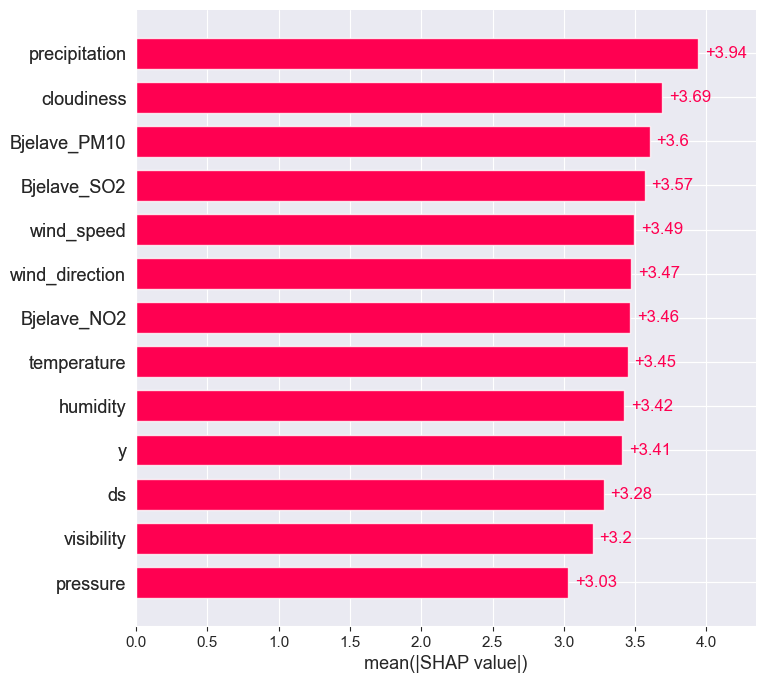

In [141]:
explainer_day_combined_ws_thirty_mod = shap.Explanation(
    values=shap_values_day_combined_ws_thirty,
    base_values=np.array([explainer_day_combined_ws_thirty.expected_value] * len(shap_values_day_combined_ws_thirty)),
    data=day_combined_to_explain_ws_thirty,
    feature_names=feature_columns_combined
)

shap.plots.bar(explainer_day_combined_ws_thirty_mod, max_display=len(feature_columns_combined))


In [133]:
feature_columns_combined_a = ["yhat" if col == "y" else col for col in feature_columns_combined]


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


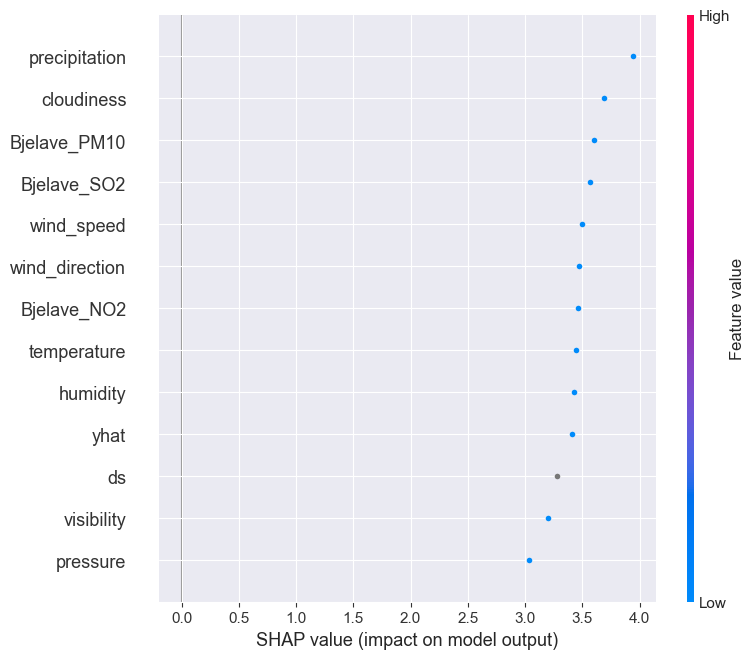

In [134]:
shap.summary_plot(shap_values_day_combined_ws_thirty, forecast_combined_ws_thirty[feature_columns_combined_a].iloc[[30]])


In [109]:
for i, val in enumerate(feature_columns_combined):
    print(f"{i}:{val}", end=" ")

0:ds 1:y 2:wind_speed 3:wind_direction 4:precipitation 5:pressure 6:temperature 7:humidity 8:visibility 9:cloudiness 10:Bjelave_PM10 11:Bjelave_SO2 12:Bjelave_NO2 

In [106]:
shap_values_day_combined_ws_thirty

array([[3.27835115, 3.40861258, 3.49353121, 3.47275589, 3.94409459,
        3.02963354, 3.44651544, 3.42455179, 3.20365053, 3.68903435,
        3.60154846, 3.5684609 , 3.46423302]])

In [88]:
explainer_day_combined_ws_sixty = shap.KernelExplainer(prophet_predict_ws_sixty_for_shap_combined, background_data_combined_ws_sixty)
shap_values_day_combined_ws_sixty = explainer_day_combined_ws_thirty.shap_values(day_combined_to_explain_ws_sixty)

  0%|          | 0/1 [00:00<?, ?it/s]

 -> len(data_df):  1
 -> type(data_df):  <class 'pandas.core.frame.DataFrame'>
 -> len(data_df):  207400
 -> type(data_df):  <class 'pandas.core.frame.DataFrame'>


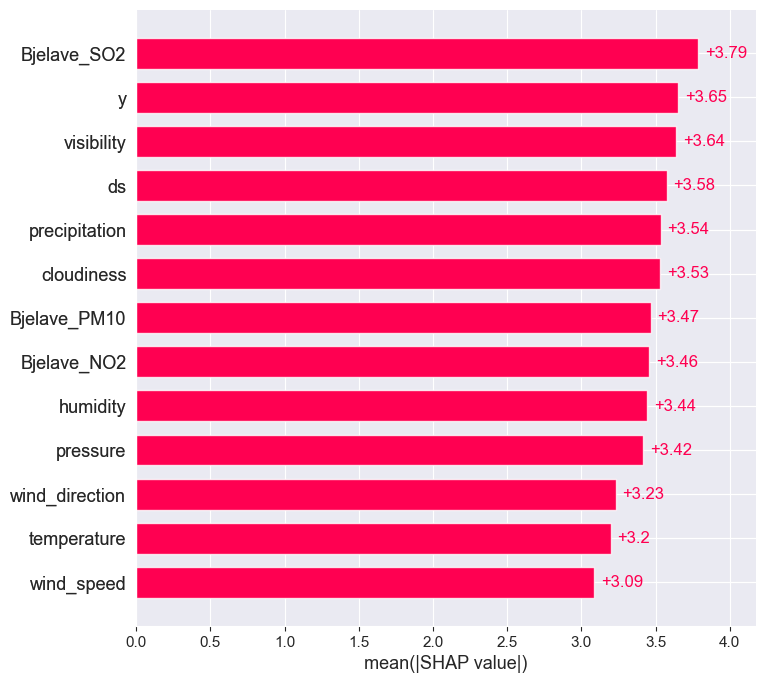

In [142]:
explainer_day_combined_ws_sixty_mod = shap.Explanation(
    values=shap_values_day_combined_ws_sixty,
    base_values=np.array([explainer_day_combined_ws_sixty.expected_value] * len(shap_values_day_combined_ws_sixty)),
    data=day_combined_to_explain_ws_sixty,
    feature_names=feature_columns_combined
)

shap.plots.bar(explainer_day_combined_ws_sixty_mod, max_display=len(feature_columns_combined))

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


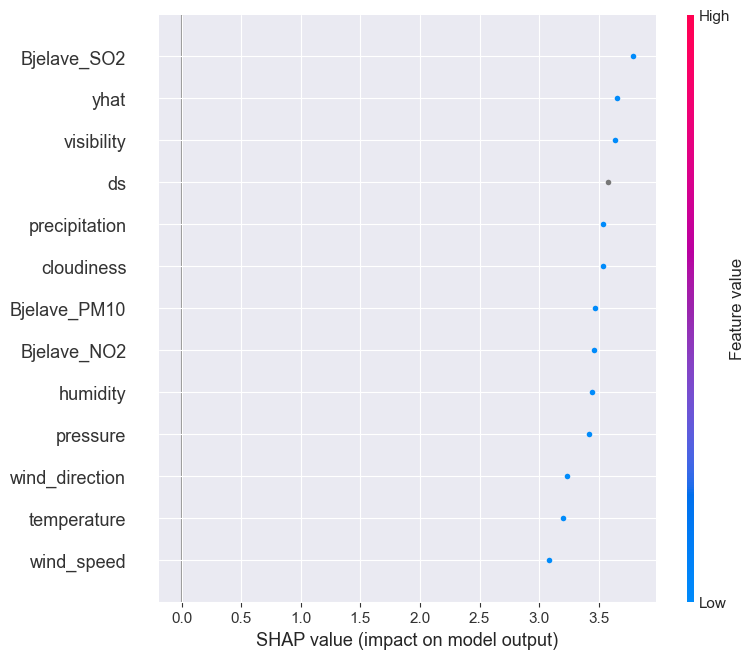

In [135]:
shap.summary_plot(shap_values_day_combined_ws_sixty, forecast_combined_ws_sixty[feature_columns_combined_a].iloc[[60]])

In [107]:
for i, val in enumerate(feature_columns_combined):
    print(f"{i}:{val}", end=" ")

0:ds 1:y 2:wind_speed 3:wind_direction 4:precipitation 5:pressure 6:temperature 7:humidity 8:visibility 9:cloudiness 10:Bjelave_PM10 11:Bjelave_SO2 12:Bjelave_NO2 

In [92]:
shap_values_day_combined_ws_sixty

array([[3.57667333, 3.65381867, 3.08567753, 3.2310613 , 3.53592177,
        3.41581145, 3.19774388, 3.44328727, 3.63980666, 3.53180932,
        3.46823653, 3.78860069, 3.45652504]])

In [89]:
explainer_day_combined_ws_ninety = shap.KernelExplainer(prophet_predict_ws_ninety_for_shap_combined, background_data_combined_ws_ninety)
shap_values_day_combined_ws_ninety = explainer_day_combined_ws_ninety.shap_values(day_combined_to_explain_ws_ninety)

  0%|          | 0/1 [00:00<?, ?it/s]

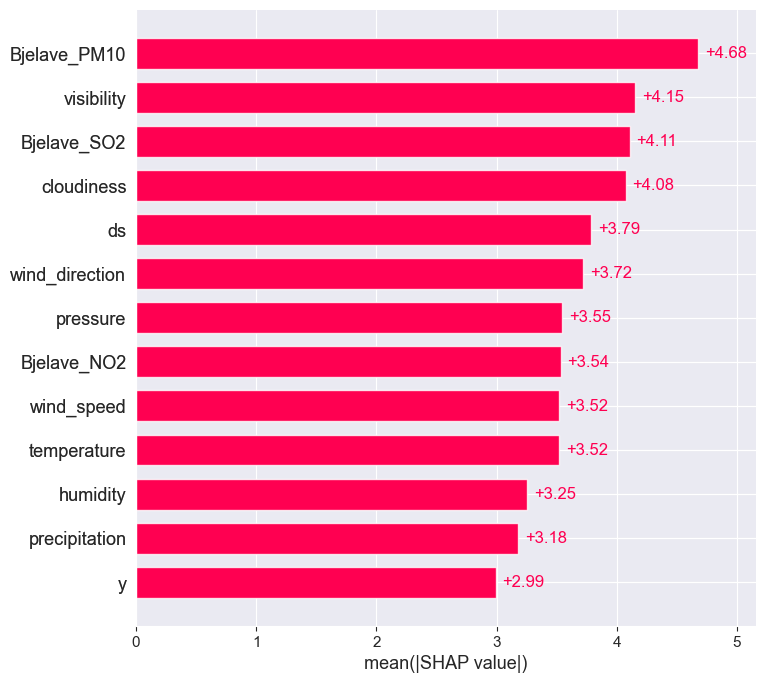

In [143]:
explainer_day_combined_ws_ninety_mod = shap.Explanation(
    values=shap_values_day_combined_ws_ninety,
    base_values=np.array([explainer_day_combined_ws_ninety.expected_value] * len(shap_values_day_combined_ws_ninety)),
    data=day_combined_to_explain_ws_ninety,
    feature_names=feature_columns_combined
)

shap.plots.bar(explainer_day_combined_ws_ninety_mod, max_display=len(feature_columns_combined))

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


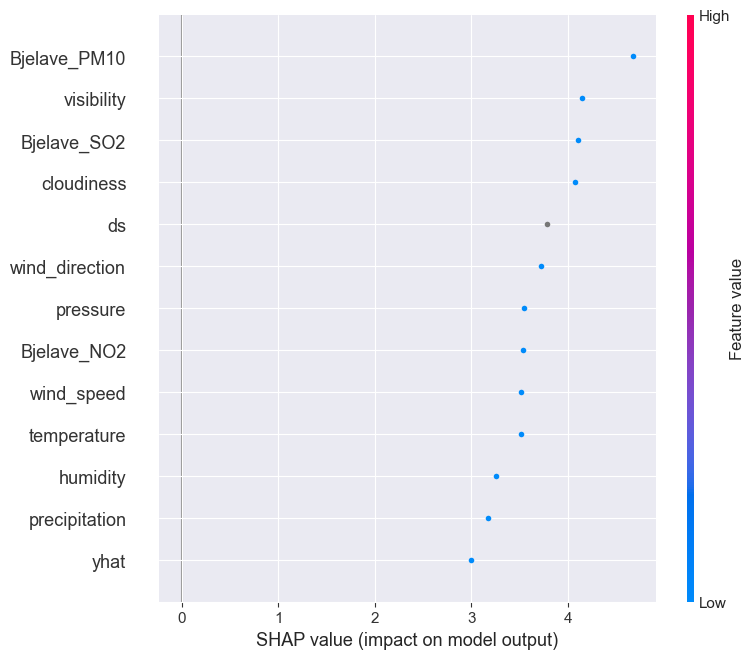

In [136]:
shap.summary_plot(shap_values_day_combined_ws_ninety, forecast_combined_ws_ninety[feature_columns_combined_a].iloc[[60]])

In [108]:
for i, val in enumerate(feature_columns_combined):
    print(f"{i}:{val}", end=" ")

0:ds 1:y 2:wind_speed 3:wind_direction 4:precipitation 5:pressure 6:temperature 7:humidity 8:visibility 9:cloudiness 10:Bjelave_PM10 11:Bjelave_SO2 12:Bjelave_NO2 

In [90]:
shap_values_day_combined_ws_ninety

array([[3.78873867, 2.9948648 , 3.52121703, 3.71972583, 3.17985752,
        3.54619307, 3.51986795, 3.25347387, 4.15347697, 4.07609262,
        4.67955515, 4.10693647, 3.53510935]])

# SHAP Analysis of Selected Forecast Horizons in Facebook Prophet Model

In [111]:
import shap

explainer_data_aqi_ws_thirty = shap.KernelExplainer(prophet_predict_ws_thirty_for_shap, background_data_aqi_ws_thirty, feature_columns_aqi)
shap_values_data_aqi_ws_thirty = explainer_data_aqi_ws_thirty.shap_values(data_aqi_to_explain_ws_thirty)

 -> len(data_df):  100
 -> type(data_df):  <class 'pandas.core.frame.DataFrame'>


  0%|          | 0/31 [00:00<?, ?it/s]

 -> len(data_df):  1
 -> type(data_df):  <class 'pandas.core.frame.DataFrame'>
 -> len(data_df):  200
 -> type(data_df):  <class 'pandas.core.frame.DataFrame'>
 -> len(data_df):  1
 -> type(data_df):  <class 'pandas.core.frame.DataFrame'>
 -> len(data_df):  200
 -> type(data_df):  <class 'pandas.core.frame.DataFrame'>
 -> len(data_df):  1
 -> type(data_df):  <class 'pandas.core.frame.DataFrame'>
 -> len(data_df):  200
 -> type(data_df):  <class 'pandas.core.frame.DataFrame'>
 -> len(data_df):  1
 -> type(data_df):  <class 'pandas.core.frame.DataFrame'>
 -> len(data_df):  200
 -> type(data_df):  <class 'pandas.core.frame.DataFrame'>
 -> len(data_df):  1
 -> type(data_df):  <class 'pandas.core.frame.DataFrame'>
 -> len(data_df):  200
 -> type(data_df):  <class 'pandas.core.frame.DataFrame'>
 -> len(data_df):  1
 -> type(data_df):  <class 'pandas.core.frame.DataFrame'>
 -> len(data_df):  200
 -> type(data_df):  <class 'pandas.core.frame.DataFrame'>
 -> len(data_df):  1
 -> type(data_df): 

In [112]:
explainer_data_aqi_ws_sixty = shap.KernelExplainer(prophet_predict_ws_sixty_for_shap, background_data_aqi_ws_sixty, feature_columns_aqi)
shap_values_data_aqi_ws_sixty = explainer_data_aqi_ws_sixty.shap_values(data_aqi_to_explain_ws_sixty)

  0%|          | 0/61 [00:00<?, ?it/s]

In [113]:
explainer_data_aqi_ws_ninety = shap.KernelExplainer(prophet_predict_ws_ninety_for_shap, background_data_aqi_ws_ninety, feature_columns_aqi)
shap_values_data_aqi_ws_ninety = explainer_data_aqi_ws_ninety.shap_values(data_aqi_to_explain_ws_ninety)

  0%|          | 0/91 [00:00<?, ?it/s]

In [ ]:
explainer_data_combined_ws_thirty = shap.KernelExplainer(prophet_predict_ws_thirty_for_shap_combined, background_data_combined_ws_thirty)
shap_values_data_combined_ws_thirty = explainer_data_combined_ws_thirty.shap_values(data_combined_to_explain_ws_thirty)

 -> len(data_df):  100
 -> type(data_df):  <class 'pandas.core.frame.DataFrame'>


  0%|          | 0/31 [00:00<?, ?it/s]

 -> len(data_df):  1
 -> type(data_df):  <class 'pandas.core.frame.DataFrame'>
 -> len(data_df):  207400
 -> type(data_df):  <class 'pandas.core.frame.DataFrame'>
 -> len(data_df):  1
 -> type(data_df):  <class 'pandas.core.frame.DataFrame'>
 -> len(data_df):  207400
 -> type(data_df):  <class 'pandas.core.frame.DataFrame'>
 -> len(data_df):  1
 -> type(data_df):  <class 'pandas.core.frame.DataFrame'>
 -> len(data_df):  207400
 -> type(data_df):  <class 'pandas.core.frame.DataFrame'>
 -> len(data_df):  1
 -> type(data_df):  <class 'pandas.core.frame.DataFrame'>
 -> len(data_df):  207400
 -> type(data_df):  <class 'pandas.core.frame.DataFrame'>
 -> len(data_df):  1
 -> type(data_df):  <class 'pandas.core.frame.DataFrame'>
 -> len(data_df):  207400
 -> type(data_df):  <class 'pandas.core.frame.DataFrame'>
 -> len(data_df):  1
 -> type(data_df):  <class 'pandas.core.frame.DataFrame'>
 -> len(data_df):  207400
 -> type(data_df):  <class 'pandas.core.frame.DataFrame'>
 -> len(data_df):  1
 

In [ ]:
explainer_data_combined_ws_sixty = shap.KernelExplainer(prophet_predict_ws_sixty_for_shap, background_data_combined_ws_sixty, feature_columns_combined)

shap_values_data_combined_ws_sixty = explainer_data_combined_ws_sixty.shap_values(data_combined_to_explain_ws_sixty, feature_columns_combined)

In [ ]:
explainer_data_combined_ws_ninety = shap.KernelExplainer(prophet_predict_ws_ninety_for_shap, background_data_combined_ws_ninety, feature_columns_combined)

shap_values_data_combined_ws_ninety = explainer_data_combined_ws_ninety.shap_values(data_combined_to_explain_ws_ninety, feature_columns_combined)